<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor



In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [5]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [7]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


Mounted at /content/drive
Epoch:  0  train loss:  0.221
Epoch:  0  validation loss:  0.084
Epoch:  1  train loss:  0.062
Epoch:  1  validation loss:  0.060
Epoch:  2  train loss:  0.038
Epoch:  2  validation loss:  0.049
Epoch:  3  train loss:  0.027
Epoch:  3  validation loss:  0.054
Epoch:  4  train loss:  0.017
Epoch:  4  validation loss:  0.048
Epoch:  5  train loss:  0.014
Epoch:  5  validation loss:  0.050
Epoch:  6  train loss:  0.009
Epoch:  6  validation loss:  0.048
Epoch:  7  train loss:  0.007
Epoch:  7  validation loss:  0.046
Epoch:  8  train loss:  0.004
Epoch:  8  validation loss:  0.044
Epoch:  9  train loss:  0.004
Epoch:  9  validation loss:  0.052
Epoch:  10  train loss:  0.006
Epoch:  10  validation loss:  0.054
Epoch:  11  train loss:  0.008
Epoch:  11  validation loss:  0.058
Epoch:  12  train loss:  0.008
Epoch:  12  validation loss:  0.054
Epoch:  13  train loss:  0.005
Epoch:  13  validation loss:  0.053
Epoch:  14  train loss:  0.004
Epoch:  14  validation lo

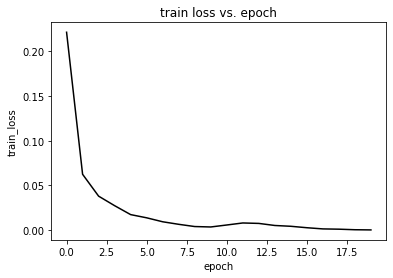

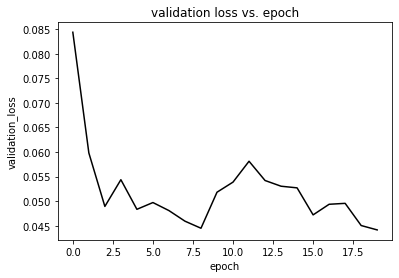

In [8]:
classifier = Classifier()
classifier.train()

In [9]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [10]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [11]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=100)
        self.bn1 = nn.BatchNorm2d(c)
        self.bn2 = nn.BatchNorm2d(c*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

In [13]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss( logits,labels):
  z = labels
  x = logits 
  #z = z * -torch.log(torch.sigmoid(x)) + (1 - z) * -torch.log(1 - torch.sigmoid(x))
  #z = z * -torch.log(1 / (1 + torch.exp(-x))) + (1 - z) * -torch.log(torch.exp(-x) / (1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (-torch.log(torch.exp(-x)) + torch.log(1 + torch.exp(-x)))
  #z = z * torch.log(1 + torch.exp(-x)) + (1 - z) * (x + torch.log(1 + torch.exp(-x)))
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


In [14]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          print("outputs: ", outputs.shape)
          print("\t", outputs)
          
          y, p_yx = torch.max(outputs.data, 1)
          print("p_yx: ", p_yx.shape)
          print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
         # print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = p_yx.cpu().data.numpy()
          print("p_yx numpy", p_yx)
          p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
          print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)
          print("p_y", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
          print("kl_d", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          print("sum_kl_d", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          print("avg_kl_d", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          print("is_score", is_score)
          print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
     
      print(is_avg, is_std)

# Creating GAN Network

In [19]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                #x_ = x_.view(x_.size(0), -1)
               # z_ = z_.view(z_.size(0), -1)
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularization

            
          
                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)
                
                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                # w parmeter = sqrt(latent dim * 1/ feature dim ) = .1562
                g = torch.mean(recon - z_) * .1562  # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradien Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
            if epoch%10 ==0:
                     # Visualize results
               with torch.no_grad():
                  print("Training at Epoch:")
                  print(epoch)
                  visualise_output(self)
                  inception_score(self)
            with torch.no_grad():
                  visualize_results(self)
          
            
           

              
           
            


        print("Training finished!")

In [16]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 3.02363062, G_loss: 0.00716025
Epoch: [ 1] [ 100/ 200] D_loss: 2.32801485, G_loss: 0.00332856
Epoch: [ 1] [ 150/ 200] D_loss: 5.13571453, G_loss: 0.02936953
Epoch: [ 1] [ 200/ 200] D_loss: 5.11702681, G_loss: 0.00669390
Training at Epoch:
0


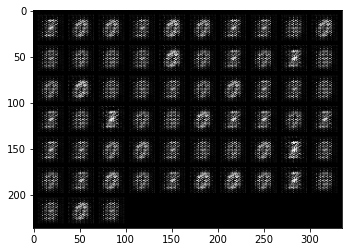

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  2.1112, 24.6264,  0.0000,  0.0000,  0.0000,  0.0000,
         11.0063,  0.0000],
        [ 0.0000,  7.5221,  0.7270,  0.0000, 21.0195,  0.0000,  0.0000,  1.6906,
          0.0000,  0.0000],
        [ 2.9661,  0.0000,  0.0000,  0.0000,  3.5952,  0.0000,  0.0000,  6.4943,
          0.2538,  1.0531],
        [10.5209,  0.0000,  0.0000,  0.0000,  0.0000,  3.4464,  0.0000,  0.0000,
          5.0423,  1.6564],
        [ 0.0000,  4.2299,  0.0000, 17.6879,  0.0000,  0.5462,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 9.3856,  0.0000,  0.0000,  0.0000,  0.0000,  2.3222,  0.0000,  0.9864,
          4.3055,  1.7887],
        [ 0.0000,  3.0899,  7.7526,  0.6667,  3.1818,  0.0000,  1.6174,  0.0000,
          0.0000,  0.0000],
        [15.6189,  0.0000,  0.0000,  0.0000,  0.0000,  7.9337,  0.0000,  0.0000,
          7.9486,  0.0000],
        [ 0.0000,  1.5736,  0.0000,  0.0000, 13.1774,  0.0000,  0.0000,  5.4748,
          0.00

<Figure size 72x720 with 0 Axes>

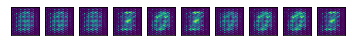

Epoch: [ 2] [  50/ 200] D_loss: 4.98439121, G_loss: 0.00835800
Epoch: [ 2] [ 100/ 200] D_loss: 6.84200668, G_loss: 0.01144326
Epoch: [ 2] [ 150/ 200] D_loss: 6.38895226, G_loss: 0.01063412
Epoch: [ 2] [ 200/ 200] D_loss: 5.64328051, G_loss: 0.00204462


<Figure size 72x720 with 0 Axes>

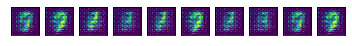

Epoch: [ 3] [  50/ 200] D_loss: 5.55691147, G_loss: 0.00030833
Epoch: [ 3] [ 100/ 200] D_loss: 5.64739084, G_loss: 0.04333597
Epoch: [ 3] [ 150/ 200] D_loss: 5.65306091, G_loss: 0.00125539
Epoch: [ 3] [ 200/ 200] D_loss: 5.42721939, G_loss: 0.00036448


<Figure size 72x720 with 0 Axes>

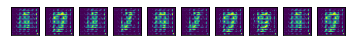

Epoch: [ 4] [  50/ 200] D_loss: 4.11647558, G_loss: 0.00840449
Epoch: [ 4] [ 100/ 200] D_loss: 6.44428825, G_loss: 0.00044179
Epoch: [ 4] [ 150/ 200] D_loss: 6.53558397, G_loss: 0.00604862
Epoch: [ 4] [ 200/ 200] D_loss: 4.36311913, G_loss: 0.00274485


<Figure size 72x720 with 0 Axes>

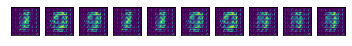

Epoch: [ 5] [  50/ 200] D_loss: 4.29514170, G_loss: 0.01171452
Epoch: [ 5] [ 100/ 200] D_loss: 5.13716412, G_loss: 0.00055021
Epoch: [ 5] [ 150/ 200] D_loss: 6.47677898, G_loss: 0.00769663
Epoch: [ 5] [ 200/ 200] D_loss: 5.88526297, G_loss: 0.01128769


<Figure size 72x720 with 0 Axes>

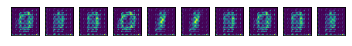

Epoch: [ 6] [  50/ 200] D_loss: 4.76453257, G_loss: 0.02328861
Epoch: [ 6] [ 100/ 200] D_loss: 6.62678814, G_loss: 0.00516266
Epoch: [ 6] [ 150/ 200] D_loss: 4.96104956, G_loss: 0.02265000
Epoch: [ 6] [ 200/ 200] D_loss: 4.84887791, G_loss: 0.00700456


<Figure size 72x720 with 0 Axes>

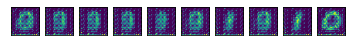

Epoch: [ 7] [  50/ 200] D_loss: 3.70514226, G_loss: 0.00834465
Epoch: [ 7] [ 100/ 200] D_loss: 4.67690134, G_loss: 0.01817685
Epoch: [ 7] [ 150/ 200] D_loss: 3.80969954, G_loss: 0.02419269
Epoch: [ 7] [ 200/ 200] D_loss: 3.40263653, G_loss: 0.04512417


<Figure size 72x720 with 0 Axes>

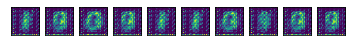

Epoch: [ 8] [  50/ 200] D_loss: 4.32371140, G_loss: 0.03179973
Epoch: [ 8] [ 100/ 200] D_loss: 2.16388750, G_loss: 0.09717441
Epoch: [ 8] [ 150/ 200] D_loss: 5.09703255, G_loss: 0.03773808
Epoch: [ 8] [ 200/ 200] D_loss: 7.09878206, G_loss: 0.04507464


<Figure size 72x720 with 0 Axes>

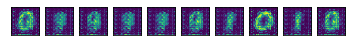

Epoch: [ 9] [  50/ 200] D_loss: 4.89738464, G_loss: 0.04182827
Epoch: [ 9] [ 100/ 200] D_loss: 3.37686014, G_loss: 0.06673062
Epoch: [ 9] [ 150/ 200] D_loss: 3.64235783, G_loss: 0.07100433
Epoch: [ 9] [ 200/ 200] D_loss: 3.71374106, G_loss: 0.09504563


<Figure size 72x720 with 0 Axes>

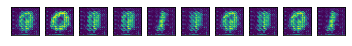

Epoch: [10] [  50/ 200] D_loss: 2.74057794, G_loss: 0.12569976
Epoch: [10] [ 100/ 200] D_loss: 3.40201211, G_loss: 0.16853017
Epoch: [10] [ 150/ 200] D_loss: 3.61886215, G_loss: 0.11520261
Epoch: [10] [ 200/ 200] D_loss: 4.32354736, G_loss: 0.21401182


<Figure size 72x720 with 0 Axes>

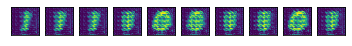

Epoch: [11] [  50/ 200] D_loss: 3.27595329, G_loss: 0.22238401
Epoch: [11] [ 100/ 200] D_loss: 3.67774677, G_loss: 0.15925294
Epoch: [11] [ 150/ 200] D_loss: 4.34627247, G_loss: 0.23186061
Epoch: [11] [ 200/ 200] D_loss: 2.05161285, G_loss: 0.21085292
Training at Epoch:
10


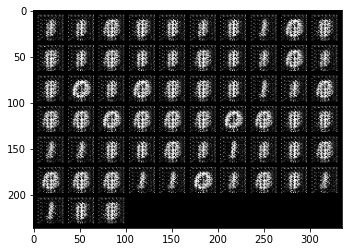

outputs:  torch.Size([10, 10])
	 tensor([[ 0.7885,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.5182,
          0.0000, 11.5100],
        [ 0.0000,  0.0000,  0.0000,  1.1115,  0.0000,  0.0000,  0.0000,  0.0000,
          4.1180,  9.2338],
        [ 0.0000,  0.0000,  5.7320, 12.3972,  0.0000,  0.0000,  0.0000,  0.5947,
          0.0000,  0.0000],
        [ 1.8773,  0.0000,  0.0000,  0.0000,  0.1671,  3.0341,  1.7554,  0.0000,
          7.6485,  1.9566],
        [ 0.0000, 12.6954,  4.4874, 14.1348,  0.0000,  4.1110,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 21.9297,  0.3708, 10.0245,  0.0000,  9.0377,  0.4675,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  7.1274, 14.1926,  0.0000,  0.0000,  0.0000,  1.0480,
          0.0000,  0.0000],
        [ 1.4352,  0.0000,  0.0000,  0.0000,  0.0401,  5.4388,  1.9433,  0.0000,
         10.7656,  0.3297],
        [19.1090,  0.0000,  9.4641,  0.0000,  0.0320,  0.0000,  0.0000,  0.0000,
          0.00

<Figure size 72x720 with 0 Axes>

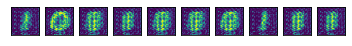

Epoch: [12] [  50/ 200] D_loss: 2.73642540, G_loss: 0.20274657
Epoch: [12] [ 100/ 200] D_loss: 5.11739731, G_loss: 0.33630919
Epoch: [12] [ 150/ 200] D_loss: 2.68052316, G_loss: 0.19438457
Epoch: [12] [ 200/ 200] D_loss: 3.69257545, G_loss: 0.34934580


<Figure size 72x720 with 0 Axes>

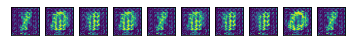

Epoch: [13] [  50/ 200] D_loss: 3.88431025, G_loss: 0.35377902
Epoch: [13] [ 100/ 200] D_loss: 1.86122060, G_loss: 0.32195076
Epoch: [13] [ 150/ 200] D_loss: 3.55222273, G_loss: 0.35749069
Epoch: [13] [ 200/ 200] D_loss: 2.76985693, G_loss: 0.27008745


<Figure size 72x720 with 0 Axes>

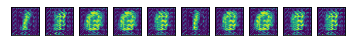

Epoch: [14] [  50/ 200] D_loss: 2.04555511, G_loss: 0.40780362
Epoch: [14] [ 100/ 200] D_loss: 1.57072365, G_loss: 0.39921042
Epoch: [14] [ 150/ 200] D_loss: 2.17021608, G_loss: 0.42200646
Epoch: [14] [ 200/ 200] D_loss: 2.91136289, G_loss: 0.43884721


<Figure size 72x720 with 0 Axes>

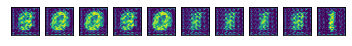

Epoch: [15] [  50/ 200] D_loss: 3.02120495, G_loss: 0.47893557
Epoch: [15] [ 100/ 200] D_loss: 6.92517424, G_loss: 0.36980709
Epoch: [15] [ 150/ 200] D_loss: 2.06152606, G_loss: 0.50060141
Epoch: [15] [ 200/ 200] D_loss: 1.73134148, G_loss: 0.45665401


<Figure size 72x720 with 0 Axes>

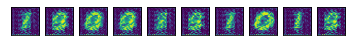

Epoch: [16] [  50/ 200] D_loss: 1.88471651, G_loss: 0.51123792
Epoch: [16] [ 100/ 200] D_loss: 8.99646091, G_loss: 0.41304961
Epoch: [16] [ 150/ 200] D_loss: 1.32636130, G_loss: 0.45314658
Epoch: [16] [ 200/ 200] D_loss: 1.51824927, G_loss: 0.47398180


<Figure size 72x720 with 0 Axes>

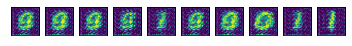

Epoch: [17] [  50/ 200] D_loss: 1.56858325, G_loss: 0.56681544
Epoch: [17] [ 100/ 200] D_loss: 5.08265257, G_loss: 0.64260972
Epoch: [17] [ 150/ 200] D_loss: 1.49879193, G_loss: 0.41815978
Epoch: [17] [ 200/ 200] D_loss: 3.43549109, G_loss: 0.59055507


<Figure size 72x720 with 0 Axes>

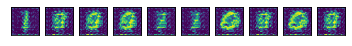

Epoch: [18] [  50/ 200] D_loss: 9.47058296, G_loss: 0.52794135
Epoch: [18] [ 100/ 200] D_loss: 1.31984663, G_loss: 0.44287327
Epoch: [18] [ 150/ 200] D_loss: 1.91285181, G_loss: 0.55692923
Epoch: [18] [ 200/ 200] D_loss: 1.79027033, G_loss: 0.56066853


<Figure size 72x720 with 0 Axes>

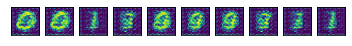

Epoch: [19] [  50/ 200] D_loss: 7.15504360, G_loss: 0.55858815
Epoch: [19] [ 100/ 200] D_loss: 1.80344963, G_loss: 0.47138074
Epoch: [19] [ 150/ 200] D_loss: 2.18829823, G_loss: 0.43998283
Epoch: [19] [ 200/ 200] D_loss: 9.86982155, G_loss: 0.57736421


<Figure size 72x720 with 0 Axes>

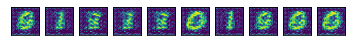

Epoch: [20] [  50/ 200] D_loss: 1.07736123, G_loss: 0.58458269
Epoch: [20] [ 100/ 200] D_loss: 4.66503191, G_loss: 0.62172157
Epoch: [20] [ 150/ 200] D_loss: 2.23545170, G_loss: 0.61110556
Epoch: [20] [ 200/ 200] D_loss: 5.90325308, G_loss: 0.59490681


<Figure size 72x720 with 0 Axes>

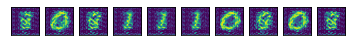

Epoch: [21] [  50/ 200] D_loss: 1.39793158, G_loss: 0.61411852
Epoch: [21] [ 100/ 200] D_loss: 3.28637028, G_loss: 0.59927440
Epoch: [21] [ 150/ 200] D_loss: 1.71757388, G_loss: 0.65145028
Epoch: [21] [ 200/ 200] D_loss: 1.28498816, G_loss: 0.67859972
Training at Epoch:
20


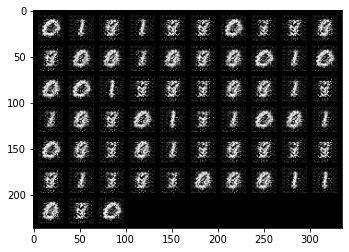

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  5.7230,  2.7401,  4.3556,  0.0000,  0.0000,  0.0000,  1.0108,
          0.0000,  0.0000],
        [24.2233,  0.0000,  1.3964,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.7759,  0.0000,  0.7905,  0.0000,  0.1803,
          4.3207,  0.0000],
        [22.7734,  0.0000,  3.0835,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 5.7677,  0.0000,  1.8949,  0.0000,  0.3085,  0.0000,  1.0006,  0.0000,
          3.8823,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0583,  2.8917,  2.6437,  0.0000,  0.1211,
          7.3998,  6.2714],
        [ 0.0000,  6.9445,  4.0500,  4.8537,  0.0000,  0.0000,  0.0000,  0.6085,
          0.0000,  0.0000],
        [10.7896,  0.0000,  6.1242,  0.0000,  1.8780,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.6414,  2.8939,  0.0000,  0.0000,  0.0000,
          8.34

<Figure size 72x720 with 0 Axes>

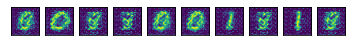

Epoch: [22] [  50/ 200] D_loss: 3.19183469, G_loss: 0.58183360
Epoch: [22] [ 100/ 200] D_loss: 0.99967504, G_loss: 0.68073219
Epoch: [22] [ 150/ 200] D_loss: 1.60407293, G_loss: 0.58766317
Epoch: [22] [ 200/ 200] D_loss: 1.40902877, G_loss: 0.65658164


<Figure size 72x720 with 0 Axes>

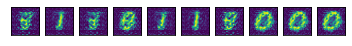

Epoch: [23] [  50/ 200] D_loss: 10.83005524, G_loss: 0.60786939
Epoch: [23] [ 100/ 200] D_loss: 1.24626672, G_loss: 0.78078544
Epoch: [23] [ 150/ 200] D_loss: 1.35700810, G_loss: 0.56753069
Epoch: [23] [ 200/ 200] D_loss: 1.66780567, G_loss: 0.65534437


<Figure size 72x720 with 0 Axes>

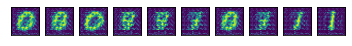

Epoch: [24] [  50/ 200] D_loss: 1.84287131, G_loss: 0.58298564
Epoch: [24] [ 100/ 200] D_loss: 2.37627554, G_loss: 0.66699147
Epoch: [24] [ 150/ 200] D_loss: 1.39666069, G_loss: 0.64112335
Epoch: [24] [ 200/ 200] D_loss: 1.06941700, G_loss: 0.65103698


<Figure size 72x720 with 0 Axes>

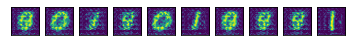

Epoch: [25] [  50/ 200] D_loss: 0.90945876, G_loss: 0.33148921
Epoch: [25] [ 100/ 200] D_loss: 1.11518037, G_loss: 0.66510278
Epoch: [25] [ 150/ 200] D_loss: 3.48645592, G_loss: 0.77443510
Epoch: [25] [ 200/ 200] D_loss: 1.17902601, G_loss: 0.59447438


<Figure size 72x720 with 0 Axes>

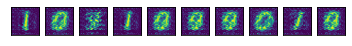

Epoch: [26] [  50/ 200] D_loss: 1.20054567, G_loss: 0.60163444
Epoch: [26] [ 100/ 200] D_loss: 1.61465013, G_loss: 0.74777544
Epoch: [26] [ 150/ 200] D_loss: 1.48750389, G_loss: 0.72850960
Epoch: [26] [ 200/ 200] D_loss: 19.60212517, G_loss: 0.55973029


<Figure size 72x720 with 0 Axes>

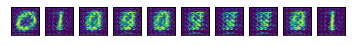

Epoch: [27] [  50/ 200] D_loss: 1.65471768, G_loss: 0.77743047
Epoch: [27] [ 100/ 200] D_loss: 6.50375652, G_loss: 0.65993661
Epoch: [27] [ 150/ 200] D_loss: 1.31109250, G_loss: 0.69517726
Epoch: [27] [ 200/ 200] D_loss: 1.13463664, G_loss: 0.57794893


<Figure size 72x720 with 0 Axes>

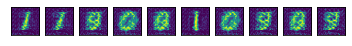

Epoch: [28] [  50/ 200] D_loss: 1.47859263, G_loss: 0.74031383
Epoch: [28] [ 100/ 200] D_loss: 1.93691278, G_loss: 0.71013123
Epoch: [28] [ 150/ 200] D_loss: 0.95102799, G_loss: 0.78739858
Epoch: [28] [ 200/ 200] D_loss: 1.34745169, G_loss: 0.76925677


<Figure size 72x720 with 0 Axes>

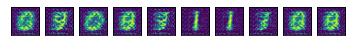

Epoch: [29] [  50/ 200] D_loss: 1.12530816, G_loss: 0.78797567
Epoch: [29] [ 100/ 200] D_loss: 1.14882290, G_loss: 0.68707746
Epoch: [29] [ 150/ 200] D_loss: 6.97872448, G_loss: 0.65646446
Epoch: [29] [ 200/ 200] D_loss: 0.92327130, G_loss: 0.74066126


<Figure size 72x720 with 0 Axes>

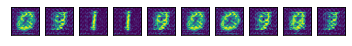

Epoch: [30] [  50/ 200] D_loss: 0.98294944, G_loss: 0.68183208
Epoch: [30] [ 100/ 200] D_loss: 1.29446459, G_loss: 0.68877506
Epoch: [30] [ 150/ 200] D_loss: 2.18129611, G_loss: 0.77154195
Epoch: [30] [ 200/ 200] D_loss: 2.52494502, G_loss: 0.76605642


<Figure size 72x720 with 0 Axes>

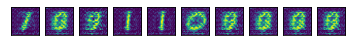

Epoch: [31] [  50/ 200] D_loss: 1.06915236, G_loss: 0.61524689
Epoch: [31] [ 100/ 200] D_loss: 2.10087395, G_loss: 0.69168878
Epoch: [31] [ 150/ 200] D_loss: 1.23956954, G_loss: 0.75294071
Epoch: [31] [ 200/ 200] D_loss: 1.50043941, G_loss: 0.76083386
Training at Epoch:
30


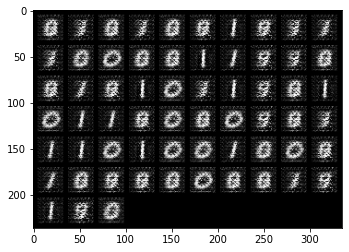

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  2.8436,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         11.4899,  3.3226],
        [ 0.0000, 40.4365,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.6912,
          0.0000,  0.0000],
        [10.3547,  0.0000,  0.0000,  0.0000,  0.0000,  0.7535,  0.4677,  0.0000,
          0.0000,  1.2651],
        [ 8.7586,  0.0000,  0.0000,  0.0000,  0.0000,  1.1948,  1.8591,  0.0000,
          0.9036,  2.3624],
        [ 0.0000, 39.7733,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  9.4008,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.4636,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          9.9785,  2.3655],
        [ 0.0000,  0.0000,  2.7828, 13.0390,  0.0000,  0.0000,  0.0000,  6.4490,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.1118,  2.5215,  0.0000,  0.0000,  0.0000,  3.0360,
         11.2555,  5.6744],
        [ 9.6712,  0.0000,  0.0000,  0.0000,  0.0000,  1.0140,  1.0576,  0.0000,
          0.09

<Figure size 72x720 with 0 Axes>

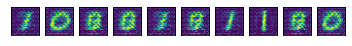

Epoch: [32] [  50/ 200] D_loss: 1.09769344, G_loss: 0.82200581
Epoch: [32] [ 100/ 200] D_loss: 3.45736384, G_loss: 0.80205601
Epoch: [32] [ 150/ 200] D_loss: 1.50517201, G_loss: 0.83841336
Epoch: [32] [ 200/ 200] D_loss: 1.55567670, G_loss: 0.84702188


<Figure size 72x720 with 0 Axes>

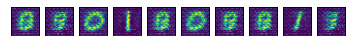

Epoch: [33] [  50/ 200] D_loss: 1.29206264, G_loss: 0.80785960
Epoch: [33] [ 100/ 200] D_loss: 6.60444355, G_loss: 0.74425769
Epoch: [33] [ 150/ 200] D_loss: 5.63253212, G_loss: 0.74084294
Epoch: [33] [ 200/ 200] D_loss: 0.92378652, G_loss: 0.76301372


<Figure size 72x720 with 0 Axes>

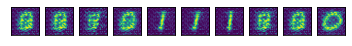

Epoch: [34] [  50/ 200] D_loss: 1.94461989, G_loss: 0.71997970
Epoch: [34] [ 100/ 200] D_loss: 2.99082637, G_loss: 0.67251122
Epoch: [34] [ 150/ 200] D_loss: 1.08156824, G_loss: 0.76323962
Epoch: [34] [ 200/ 200] D_loss: 12.94919968, G_loss: 0.35287425


<Figure size 72x720 with 0 Axes>

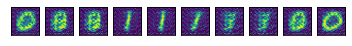

Epoch: [35] [  50/ 200] D_loss: 1.09629178, G_loss: 0.78500330
Epoch: [35] [ 100/ 200] D_loss: 0.94195658, G_loss: 0.66948199
Epoch: [35] [ 150/ 200] D_loss: 9.26758575, G_loss: 0.77870148
Epoch: [35] [ 200/ 200] D_loss: 0.95755655, G_loss: 0.74355978


<Figure size 72x720 with 0 Axes>

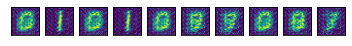

Epoch: [36] [  50/ 200] D_loss: 3.89529610, G_loss: 0.70117462
Epoch: [36] [ 100/ 200] D_loss: 0.91806525, G_loss: 0.74148554
Epoch: [36] [ 150/ 200] D_loss: 2.08324432, G_loss: 0.79013127
Epoch: [36] [ 200/ 200] D_loss: 0.87971866, G_loss: 0.79899377


<Figure size 72x720 with 0 Axes>

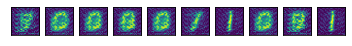

Epoch: [37] [  50/ 200] D_loss: 0.97831345, G_loss: 0.77546132
Epoch: [37] [ 100/ 200] D_loss: 1.14104593, G_loss: 0.74437940
Epoch: [37] [ 150/ 200] D_loss: 1.06596148, G_loss: 0.79111665
Epoch: [37] [ 200/ 200] D_loss: 1.22449958, G_loss: 0.84702665


<Figure size 72x720 with 0 Axes>

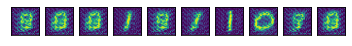

Epoch: [38] [  50/ 200] D_loss: 1.09183812, G_loss: 0.72702652
Epoch: [38] [ 100/ 200] D_loss: 1.61808777, G_loss: 0.86760068
Epoch: [38] [ 150/ 200] D_loss: 1.44580972, G_loss: 0.74740785
Epoch: [38] [ 200/ 200] D_loss: 21.81753159, G_loss: 0.85340726


<Figure size 72x720 with 0 Axes>

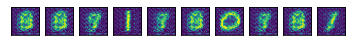

Epoch: [39] [  50/ 200] D_loss: 1.68345380, G_loss: 0.76555967
Epoch: [39] [ 100/ 200] D_loss: 1.78033888, G_loss: 0.86434579
Epoch: [39] [ 150/ 200] D_loss: 1.09475839, G_loss: 0.88657463
Epoch: [39] [ 200/ 200] D_loss: 1.50769210, G_loss: 0.79606235


<Figure size 72x720 with 0 Axes>

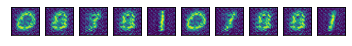

Epoch: [40] [  50/ 200] D_loss: 1.97315109, G_loss: 0.74229151
Epoch: [40] [ 100/ 200] D_loss: 1.05176675, G_loss: 0.78106499
Epoch: [40] [ 150/ 200] D_loss: 1.21561146, G_loss: 0.76494473
Epoch: [40] [ 200/ 200] D_loss: 1.38316011, G_loss: 0.72923970


<Figure size 72x720 with 0 Axes>

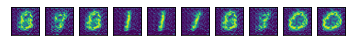

Epoch: [41] [  50/ 200] D_loss: 1.27061176, G_loss: 0.76666951
Epoch: [41] [ 100/ 200] D_loss: 1.02824140, G_loss: 0.70104945
Epoch: [41] [ 150/ 200] D_loss: 1.29001260, G_loss: 0.83307368
Epoch: [41] [ 200/ 200] D_loss: 1.26416874, G_loss: 0.83032888
Training at Epoch:
40


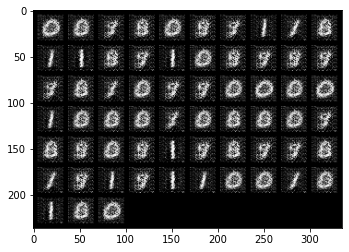

outputs:  torch.Size([10, 10])
	 tensor([[10.7114,  0.0000,  7.9382,  0.0000,  0.0000,  0.0000,  7.6426,  0.0000,
          2.0309,  0.0000],
        [ 0.0000,  0.0000,  1.7424,  0.0000,  0.0000,  0.7387,  0.0000,  0.0000,
         14.4778,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  3.1934,
          8.8318, 11.5239],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.4275,  0.0000,  0.0000,  1.0499,
          8.4157, 12.7723],
        [ 0.0000, 36.0955,  0.0000,  2.4888,  0.0000,  0.0000,  0.0000,  9.1705,
          0.0000,  0.0000],
        [ 0.0000, 35.6034,  0.0000,  8.3256,  0.0000,  0.0000,  0.0000,  9.2669,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1017, 10.9032,  0.0000,  0.0000,  0.0000,  0.0000,
          4.7032,  0.0000],
        [19.9660,  0.0000,  7.2560,  0.0000,  0.0000,  0.0000,  4.2611,  0.0000,
          0.0000,  0.0000],
        [ 3.9984,  0.0000,  8.5277,  0.0000,  0.0000,  0.0000,  7.3600,  0.0000,
          5.95

<Figure size 72x720 with 0 Axes>

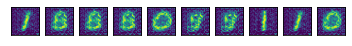

Epoch: [42] [  50/ 200] D_loss: 1.29347467, G_loss: 0.70230103
Epoch: [42] [ 100/ 200] D_loss: 0.93212616, G_loss: 0.76863015
Epoch: [42] [ 150/ 200] D_loss: 1.82020950, G_loss: 0.76352662
Epoch: [42] [ 200/ 200] D_loss: 1.65801692, G_loss: 0.73918837


<Figure size 72x720 with 0 Axes>

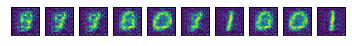

Epoch: [43] [  50/ 200] D_loss: 1.26173937, G_loss: 0.77018499
Epoch: [43] [ 100/ 200] D_loss: 1.48427141, G_loss: 0.80461079
Epoch: [43] [ 150/ 200] D_loss: 1.02201319, G_loss: 0.76674658
Epoch: [43] [ 200/ 200] D_loss: 1.18047190, G_loss: 0.81601256


<Figure size 72x720 with 0 Axes>

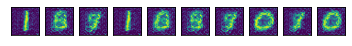

Epoch: [44] [  50/ 200] D_loss: 0.95172244, G_loss: 0.81006581
Epoch: [44] [ 100/ 200] D_loss: 1.43813682, G_loss: 0.79086089
Epoch: [44] [ 150/ 200] D_loss: 1.11311364, G_loss: 0.86531818
Epoch: [44] [ 200/ 200] D_loss: 1.10211480, G_loss: 0.79585791


<Figure size 72x720 with 0 Axes>

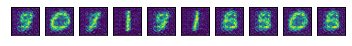

Epoch: [45] [  50/ 200] D_loss: 1.08242583, G_loss: 0.83579695
Epoch: [45] [ 100/ 200] D_loss: 1.09353375, G_loss: 0.77239871
Epoch: [45] [ 150/ 200] D_loss: 1.58371937, G_loss: 0.84333956
Epoch: [45] [ 200/ 200] D_loss: 1.00703514, G_loss: 0.73992479


<Figure size 72x720 with 0 Axes>

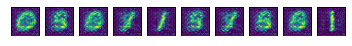

Epoch: [46] [  50/ 200] D_loss: 1.11719072, G_loss: 0.72916526
Epoch: [46] [ 100/ 200] D_loss: 1.00001466, G_loss: 0.62910956
Epoch: [46] [ 150/ 200] D_loss: 2.53205347, G_loss: 0.79214525
Epoch: [46] [ 200/ 200] D_loss: 10.20434380, G_loss: 0.81242287


<Figure size 72x720 with 0 Axes>

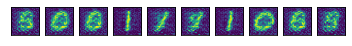

Epoch: [47] [  50/ 200] D_loss: 2.03393531, G_loss: 0.71336621
Epoch: [47] [ 100/ 200] D_loss: 1.07622051, G_loss: 0.81643116
Epoch: [47] [ 150/ 200] D_loss: 1.28374732, G_loss: 0.84286124
Epoch: [47] [ 200/ 200] D_loss: 1.71129727, G_loss: 0.71933019


<Figure size 72x720 with 0 Axes>

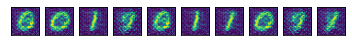

Epoch: [48] [  50/ 200] D_loss: 3.14465690, G_loss: 0.76564246
Epoch: [48] [ 100/ 200] D_loss: 1.36087942, G_loss: 0.82173574
Epoch: [48] [ 150/ 200] D_loss: 1.19647670, G_loss: 0.84196353
Epoch: [48] [ 200/ 200] D_loss: 1.17286873, G_loss: 0.83199263


<Figure size 72x720 with 0 Axes>

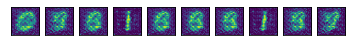

Epoch: [49] [  50/ 200] D_loss: 1.19431722, G_loss: 0.82314968
Epoch: [49] [ 100/ 200] D_loss: 1.18328571, G_loss: 0.84227312
Epoch: [49] [ 150/ 200] D_loss: 1.39533174, G_loss: 0.80559731
Epoch: [49] [ 200/ 200] D_loss: 2.54791546, G_loss: 0.80714834


<Figure size 72x720 with 0 Axes>

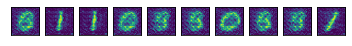

Epoch: [50] [  50/ 200] D_loss: 1.60335851, G_loss: 0.89834350
Epoch: [50] [ 100/ 200] D_loss: 2.90383267, G_loss: 0.77630091
Epoch: [50] [ 150/ 200] D_loss: 1.93257773, G_loss: 0.73691392
Epoch: [50] [ 200/ 200] D_loss: 1.65492010, G_loss: 0.72328329


<Figure size 72x720 with 0 Axes>

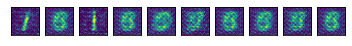

Epoch: [51] [  50/ 200] D_loss: 2.66067076, G_loss: 0.85414016
Epoch: [51] [ 100/ 200] D_loss: 1.28038120, G_loss: 0.69520760
Epoch: [51] [ 150/ 200] D_loss: 1.25126827, G_loss: 0.87307382
Epoch: [51] [ 200/ 200] D_loss: 1.11982393, G_loss: 0.81493020
Training at Epoch:
50


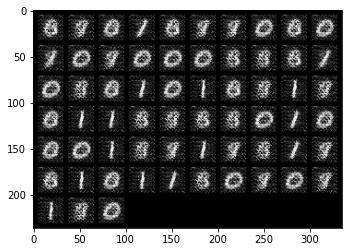

outputs:  torch.Size([10, 10])
	 tensor([[ 1.4810,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  4.1510,  0.0000,
          7.7706,  3.3469],
        [ 0.0000, 39.3042,  0.0000,  2.5376,  0.0000,  0.0000,  0.0000,  9.2751,
          0.0000,  0.0000],
        [10.3810,  0.0000,  1.3010,  0.0000,  0.0000,  0.4260,  0.0000,  3.3221,
          0.0000,  0.0000],
        [ 8.4981,  0.0000,  0.7915,  0.0000,  0.0000,  0.0000,  0.0000,  2.1766,
          0.0000,  0.6391],
        [ 5.4301,  0.0000,  1.3288,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0564,  1.7242],
        [ 0.0000,  0.0000,  0.0000,  2.5828,  0.0000,  0.0000,  0.0000,  0.0000,
         22.4009,  6.2391],
        [ 7.3861,  0.0000,  0.8775,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.4021],
        [ 3.9380,  0.0000,  1.0262,  0.0000,  0.0000,  0.0000,  2.0000,  0.0000,
          5.2809,  2.6834],
        [ 0.0000, 31.8206,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 13.6143,
          0.00

<Figure size 72x720 with 0 Axes>

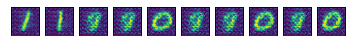

Epoch: [52] [  50/ 200] D_loss: 1.21177924, G_loss: 0.66409647
Epoch: [52] [ 100/ 200] D_loss: 1.25290227, G_loss: 0.87343532
Epoch: [52] [ 150/ 200] D_loss: 3.30170679, G_loss: 0.82768929
Epoch: [52] [ 200/ 200] D_loss: 6.40302801, G_loss: 0.85463488


<Figure size 72x720 with 0 Axes>

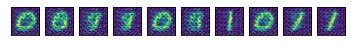

Epoch: [53] [  50/ 200] D_loss: 2.68589878, G_loss: 0.86053807
Epoch: [53] [ 100/ 200] D_loss: 1.31399870, G_loss: 0.61171317
Epoch: [53] [ 150/ 200] D_loss: 1.19209468, G_loss: 0.80081367
Epoch: [53] [ 200/ 200] D_loss: 1.25149965, G_loss: 0.81412446


<Figure size 72x720 with 0 Axes>

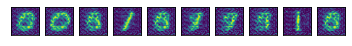

Epoch: [54] [  50/ 200] D_loss: 2.20025158, G_loss: 0.79675490
Epoch: [54] [ 100/ 200] D_loss: 1.51501608, G_loss: 0.76850975
Epoch: [54] [ 150/ 200] D_loss: 1.34552491, G_loss: 0.88016963
Epoch: [54] [ 200/ 200] D_loss: 1.31203747, G_loss: 0.86313623


<Figure size 72x720 with 0 Axes>

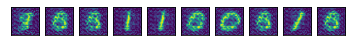

Epoch: [55] [  50/ 200] D_loss: 3.52926970, G_loss: 0.80111134
Epoch: [55] [ 100/ 200] D_loss: 1.52086949, G_loss: 0.90575743
Epoch: [55] [ 150/ 200] D_loss: 1.43256438, G_loss: 0.74926960
Epoch: [55] [ 200/ 200] D_loss: 2.23543787, G_loss: 0.78315914


<Figure size 72x720 with 0 Axes>

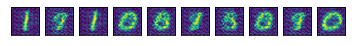

Epoch: [56] [  50/ 200] D_loss: 1.20471513, G_loss: 0.80626249
Epoch: [56] [ 100/ 200] D_loss: 1.20981622, G_loss: 0.84684074
Epoch: [56] [ 150/ 200] D_loss: 1.53925598, G_loss: 0.90125984
Epoch: [56] [ 200/ 200] D_loss: 2.84271264, G_loss: 0.75025058


<Figure size 72x720 with 0 Axes>

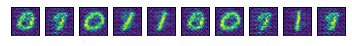

Epoch: [57] [  50/ 200] D_loss: 1.54142213, G_loss: 0.90693688
Epoch: [57] [ 100/ 200] D_loss: 1.48371136, G_loss: 0.76006949
Epoch: [57] [ 150/ 200] D_loss: 2.46283007, G_loss: 0.82476723
Epoch: [57] [ 200/ 200] D_loss: 2.19149971, G_loss: 0.77075899


<Figure size 72x720 with 0 Axes>

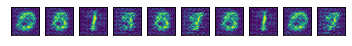

Epoch: [58] [  50/ 200] D_loss: 1.17684221, G_loss: 0.71752661
Epoch: [58] [ 100/ 200] D_loss: 1.01376140, G_loss: 0.82744747
Epoch: [58] [ 150/ 200] D_loss: 1.35775781, G_loss: 0.78307319
Epoch: [58] [ 200/ 200] D_loss: 1.27865005, G_loss: 0.81873691


<Figure size 72x720 with 0 Axes>

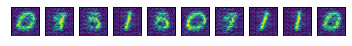

Epoch: [59] [  50/ 200] D_loss: 13.44568062, G_loss: 0.71537012
Epoch: [59] [ 100/ 200] D_loss: 1.81641459, G_loss: 0.82704765
Epoch: [59] [ 150/ 200] D_loss: 1.33704638, G_loss: 0.82439482
Epoch: [59] [ 200/ 200] D_loss: 2.48361635, G_loss: 0.79479933


<Figure size 72x720 with 0 Axes>

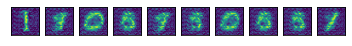

Epoch: [60] [  50/ 200] D_loss: 1.23470545, G_loss: 0.89977574
Epoch: [60] [ 100/ 200] D_loss: 1.27015305, G_loss: 0.81994027
Epoch: [60] [ 150/ 200] D_loss: 1.42371333, G_loss: 0.86982810
Epoch: [60] [ 200/ 200] D_loss: 1.32101548, G_loss: 0.86756480


<Figure size 72x720 with 0 Axes>

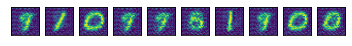

Epoch: [61] [  50/ 200] D_loss: 1.28558445, G_loss: 0.80662519
Epoch: [61] [ 100/ 200] D_loss: 1.51904559, G_loss: 0.67695153
Epoch: [61] [ 150/ 200] D_loss: 1.33380842, G_loss: 0.79073560
Epoch: [61] [ 200/ 200] D_loss: 1.00488281, G_loss: 0.60813856
Training at Epoch:
60


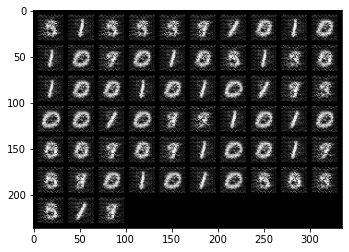

outputs:  torch.Size([10, 10])
	 tensor([[24.7532,  0.0000,  4.8362,  0.0000,  0.0000,  0.0000,  1.8539,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 25.6145,  0.1898,  4.0470,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.8676,  0.0367,  0.0000,  0.0000,  0.0000,  0.0000,
         11.2168,  3.9860],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1917,
          9.0553,  8.3802],
        [ 0.0000,  0.0000,  0.0000,  2.5215,  0.0000,  0.1027,  0.0000,  0.0000,
          9.5320, 14.1290],
        [ 0.0000, 18.8340, 11.6450,  0.7694,  0.0000,  0.0000,  0.0000,  9.7146,
          0.0000,  0.0000],
        [16.8293,  0.0000,  1.9576,  0.0000,  0.0000,  0.0000,  3.3952,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 24.9130,  5.5269,  0.0000,  0.0000,  0.0000,  0.0000,  4.4770,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1072,  0.0000,  0.0000,
          9.67

<Figure size 72x720 with 0 Axes>

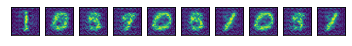

Epoch: [62] [  50/ 200] D_loss: 1.16130733, G_loss: 0.83298212
Epoch: [62] [ 100/ 200] D_loss: 1.22057128, G_loss: 0.85744846
Epoch: [62] [ 150/ 200] D_loss: 1.38543820, G_loss: 0.67942965
Epoch: [62] [ 200/ 200] D_loss: 1.38303387, G_loss: 0.78381103


<Figure size 72x720 with 0 Axes>

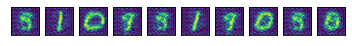

Epoch: [63] [  50/ 200] D_loss: 2.02028322, G_loss: 0.83968419
Epoch: [63] [ 100/ 200] D_loss: 2.86402154, G_loss: 0.71932417
Epoch: [63] [ 150/ 200] D_loss: 1.37397408, G_loss: 0.71459472
Epoch: [63] [ 200/ 200] D_loss: 1.41403663, G_loss: 0.83645558


<Figure size 72x720 with 0 Axes>

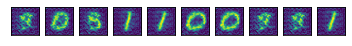

Epoch: [64] [  50/ 200] D_loss: 1.72870958, G_loss: 0.76531881
Epoch: [64] [ 100/ 200] D_loss: 1.30432558, G_loss: 0.73002487
Epoch: [64] [ 150/ 200] D_loss: 1.57382774, G_loss: 0.90263271
Epoch: [64] [ 200/ 200] D_loss: 1.31520081, G_loss: 0.74065149


<Figure size 72x720 with 0 Axes>

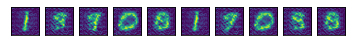

Epoch: [65] [  50/ 200] D_loss: 1.31377816, G_loss: 0.83050406
Epoch: [65] [ 100/ 200] D_loss: 1.55561674, G_loss: 0.80980456
Epoch: [65] [ 150/ 200] D_loss: 1.21992981, G_loss: 0.76052362
Epoch: [65] [ 200/ 200] D_loss: 1.20178699, G_loss: 0.81237108


<Figure size 72x720 with 0 Axes>

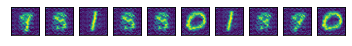

Epoch: [66] [  50/ 200] D_loss: 1.16848660, G_loss: 0.76093608
Epoch: [66] [ 100/ 200] D_loss: 2.08221292, G_loss: 0.81136310
Epoch: [66] [ 150/ 200] D_loss: 1.43199670, G_loss: 0.82421809
Epoch: [66] [ 200/ 200] D_loss: 1.04512680, G_loss: 0.83229250


<Figure size 72x720 with 0 Axes>

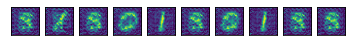

Epoch: [67] [  50/ 200] D_loss: 1.18615746, G_loss: 0.75799096
Epoch: [67] [ 100/ 200] D_loss: 1.21118164, G_loss: 0.79367334
Epoch: [67] [ 150/ 200] D_loss: 1.42105293, G_loss: 0.66189015
Epoch: [67] [ 200/ 200] D_loss: 1.74092102, G_loss: 0.72618085


<Figure size 72x720 with 0 Axes>

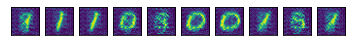

Epoch: [68] [  50/ 200] D_loss: 1.59569490, G_loss: 0.80179423
Epoch: [68] [ 100/ 200] D_loss: 1.41165781, G_loss: 0.77136570
Epoch: [68] [ 150/ 200] D_loss: 1.19662285, G_loss: 0.69978184
Epoch: [68] [ 200/ 200] D_loss: 3.65290785, G_loss: 0.60561520


<Figure size 72x720 with 0 Axes>

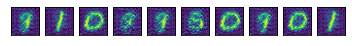

Epoch: [69] [  50/ 200] D_loss: 1.36260843, G_loss: 0.89268219
Epoch: [69] [ 100/ 200] D_loss: 1.34985018, G_loss: 0.82643372
Epoch: [69] [ 150/ 200] D_loss: 1.57010806, G_loss: 0.85866523
Epoch: [69] [ 200/ 200] D_loss: 1.51249480, G_loss: 0.62052500


<Figure size 72x720 with 0 Axes>

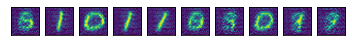

Epoch: [70] [  50/ 200] D_loss: 2.01985741, G_loss: 0.86983252
Epoch: [70] [ 100/ 200] D_loss: 1.88380075, G_loss: 0.84703475
Epoch: [70] [ 150/ 200] D_loss: 1.57599843, G_loss: 0.87794060
Epoch: [70] [ 200/ 200] D_loss: 9.14978123, G_loss: 0.67886281


<Figure size 72x720 with 0 Axes>

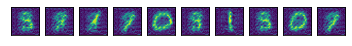

Epoch: [71] [  50/ 200] D_loss: 1.34506333, G_loss: 0.71054584
Epoch: [71] [ 100/ 200] D_loss: 2.01602530, G_loss: 0.74830908
Epoch: [71] [ 150/ 200] D_loss: 1.35477591, G_loss: 0.79033709
Epoch: [71] [ 200/ 200] D_loss: 1.34196770, G_loss: 0.83642018
Training at Epoch:
70


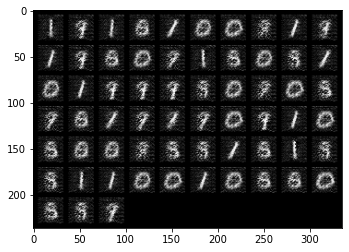

outputs:  torch.Size([10, 10])
	 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7663e+00, 0.0000e+00, 4.6722e+00,
         0.0000e+00, 0.0000e+00, 5.8545e+00, 6.0125e+00],
        [0.0000e+00, 4.6148e+01, 9.6385e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.2237e+00, 1.9610e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.0733e-01, 7.3131e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 7.6023e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 9.9724e+00, 0.0000e+00, 0.0000e+00],
        [2.9824e+01, 0.0000e+00, 9.0414e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.6283e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.6074e-03, 0.0000e+00, 3.1657e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0484e+01, 0.0000e+00, 4.0199e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3025e+01, 0.0000e+00, 9.2318e+00,
         0.0000e+00, 0.0000e+00, 6.0975e+00, 5.3796e

<Figure size 72x720 with 0 Axes>

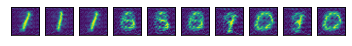

Epoch: [72] [  50/ 200] D_loss: 1.04713655, G_loss: 0.76627707
Epoch: [72] [ 100/ 200] D_loss: 2.71163726, G_loss: 0.70692503
Epoch: [72] [ 150/ 200] D_loss: 1.48641634, G_loss: 0.86077964
Epoch: [72] [ 200/ 200] D_loss: 29.68725014, G_loss: 0.73185563


<Figure size 72x720 with 0 Axes>

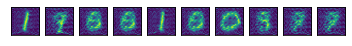

Epoch: [73] [  50/ 200] D_loss: 2.39007759, G_loss: 0.59785831
Epoch: [73] [ 100/ 200] D_loss: 1.59531450, G_loss: 0.77079225
Epoch: [73] [ 150/ 200] D_loss: 1.28957570, G_loss: 0.60274744
Epoch: [73] [ 200/ 200] D_loss: 6.91488266, G_loss: 0.61906135


<Figure size 72x720 with 0 Axes>

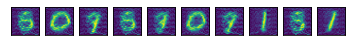

Epoch: [74] [  50/ 200] D_loss: 1.88092470, G_loss: 0.82484549
Epoch: [74] [ 100/ 200] D_loss: 1.73121631, G_loss: 0.77429402
Epoch: [74] [ 150/ 200] D_loss: 1.55271292, G_loss: 0.60594290
Epoch: [74] [ 200/ 200] D_loss: 1.06916261, G_loss: 0.82845938


<Figure size 72x720 with 0 Axes>

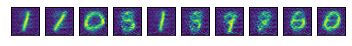

Epoch: [75] [  50/ 200] D_loss: 1.82764053, G_loss: 0.74439049
Epoch: [75] [ 100/ 200] D_loss: 1.28209662, G_loss: 0.84868020
Epoch: [75] [ 150/ 200] D_loss: 1.67361021, G_loss: 0.79268837
Epoch: [75] [ 200/ 200] D_loss: 1.58897102, G_loss: 0.71580052


<Figure size 72x720 with 0 Axes>

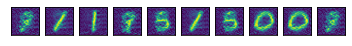

Epoch: [76] [  50/ 200] D_loss: 1.53604472, G_loss: 0.76673335
Epoch: [76] [ 100/ 200] D_loss: 1.59026015, G_loss: 0.87853277
Epoch: [76] [ 150/ 200] D_loss: 9.39455700, G_loss: 0.76407474
Epoch: [76] [ 200/ 200] D_loss: 1.89729512, G_loss: 0.84796602


<Figure size 72x720 with 0 Axes>

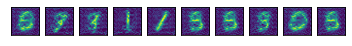

Epoch: [77] [  50/ 200] D_loss: 3.04103136, G_loss: 0.54821062
Epoch: [77] [ 100/ 200] D_loss: 1.73119318, G_loss: 0.76977587
Epoch: [77] [ 150/ 200] D_loss: 2.47465706, G_loss: 0.69632030
Epoch: [77] [ 200/ 200] D_loss: 3.72845578, G_loss: 0.73635530


<Figure size 72x720 with 0 Axes>

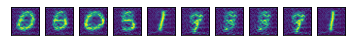

Epoch: [78] [  50/ 200] D_loss: 1.59346616, G_loss: 0.79338771
Epoch: [78] [ 100/ 200] D_loss: 1.52620006, G_loss: 0.72350633
Epoch: [78] [ 150/ 200] D_loss: 1.42130494, G_loss: 0.80125529
Epoch: [78] [ 200/ 200] D_loss: 4.65471840, G_loss: 0.68234420


<Figure size 72x720 with 0 Axes>

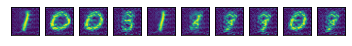

Epoch: [79] [  50/ 200] D_loss: 3.23992991, G_loss: 0.73983717
Epoch: [79] [ 100/ 200] D_loss: 1.43758082, G_loss: 0.76164842
Epoch: [79] [ 150/ 200] D_loss: 1.26179349, G_loss: 0.80751508
Epoch: [79] [ 200/ 200] D_loss: 1.24381804, G_loss: 0.74142361


<Figure size 72x720 with 0 Axes>

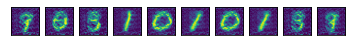

Epoch: [80] [  50/ 200] D_loss: 1.14050913, G_loss: 0.64895159
Epoch: [80] [ 100/ 200] D_loss: 1.43391764, G_loss: 0.75989640
Epoch: [80] [ 150/ 200] D_loss: 2.50154543, G_loss: 0.58032560
Epoch: [80] [ 200/ 200] D_loss: 1.05047488, G_loss: 0.85165232


<Figure size 72x720 with 0 Axes>

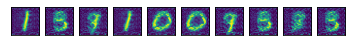

Epoch: [81] [  50/ 200] D_loss: 1.15789723, G_loss: 0.81259489
Epoch: [81] [ 100/ 200] D_loss: 1.37303495, G_loss: 0.76668465
Epoch: [81] [ 150/ 200] D_loss: 1.48304844, G_loss: 0.85063636
Epoch: [81] [ 200/ 200] D_loss: 2.05052519, G_loss: 0.79574108
Training at Epoch:
80


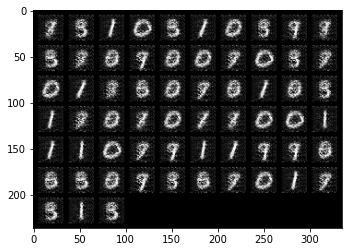

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  3.1178,  2.3245,  0.0000,  0.0000,  0.0000,  0.0000,
         12.6347,  0.9274],
        [18.5786,  0.0000,  4.8352,  0.0000,  0.0000,  0.0000,  1.3563,  0.0000,
          0.0000,  0.0000],
        [21.6056,  0.0000,  3.1731,  0.0000,  0.0000,  0.0000,  2.9169,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 14.5138,  0.0000,  8.0659,  0.0000,  0.0000,
          9.7622,  7.1137],
        [ 0.0000, 37.0564, 10.8488,  0.0000,  0.0000,  0.0000,  0.0000,  9.3984,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  4.7235,  0.0000,  0.0000,  0.0000,  5.3305,
          2.9776, 10.5206],
        [ 0.0000,  0.0000,  0.0000,  9.3941,  0.0000,  8.6157,  0.0000,  0.0000,
          8.3232,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.9811,  0.0000,  0.0000,  0.0000,  9.1493,
          0.0000, 14.0213],
        [11.9303,  0.0000,  9.4857,  0.0000,  0.0000,  0.0000,  3.7472,  0.0000,
          0.00

<Figure size 72x720 with 0 Axes>

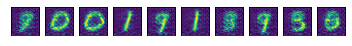

Epoch: [82] [  50/ 200] D_loss: 1.61700606, G_loss: 0.73043245
Epoch: [82] [ 100/ 200] D_loss: 2.86914539, G_loss: 0.83346856
Epoch: [82] [ 150/ 200] D_loss: 7.14451265, G_loss: 0.83784229
Epoch: [82] [ 200/ 200] D_loss: 1.45487380, G_loss: 0.79407907


<Figure size 72x720 with 0 Axes>

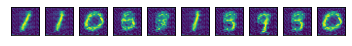

Epoch: [83] [  50/ 200] D_loss: 2.88007522, G_loss: 0.85929871
Epoch: [83] [ 100/ 200] D_loss: 1.45373940, G_loss: 0.58688390
Epoch: [83] [ 150/ 200] D_loss: 1.22323263, G_loss: 0.86473292
Epoch: [83] [ 200/ 200] D_loss: 1.73610353, G_loss: 0.87569159


<Figure size 72x720 with 0 Axes>

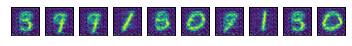

Epoch: [84] [  50/ 200] D_loss: 1.08846879, G_loss: 0.71078873
Epoch: [84] [ 100/ 200] D_loss: 1.32898307, G_loss: 0.86562347
Epoch: [84] [ 150/ 200] D_loss: 1.18512940, G_loss: 0.73640138
Epoch: [84] [ 200/ 200] D_loss: 7.24929333, G_loss: 0.72619617


<Figure size 72x720 with 0 Axes>

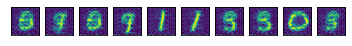

Epoch: [85] [  50/ 200] D_loss: 1.39273095, G_loss: 0.78285557
Epoch: [85] [ 100/ 200] D_loss: 5.04485226, G_loss: 0.78435141
Epoch: [85] [ 150/ 200] D_loss: 1.33583117, G_loss: 0.75102848
Epoch: [85] [ 200/ 200] D_loss: 1.73588514, G_loss: 0.83875102


<Figure size 72x720 with 0 Axes>

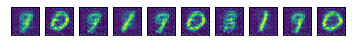

Epoch: [86] [  50/ 200] D_loss: 2.36269951, G_loss: 0.76515341
Epoch: [86] [ 100/ 200] D_loss: 1.85930002, G_loss: 0.77128375
Epoch: [86] [ 150/ 200] D_loss: 1.43750083, G_loss: 0.81975752
Epoch: [86] [ 200/ 200] D_loss: 1.13328373, G_loss: 0.59132212


<Figure size 72x720 with 0 Axes>

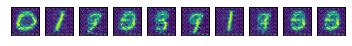

Epoch: [87] [  50/ 200] D_loss: 1.59740162, G_loss: 0.70204312
Epoch: [87] [ 100/ 200] D_loss: 1.16688585, G_loss: 0.51338100
Epoch: [87] [ 150/ 200] D_loss: 1.13045466, G_loss: 0.88556719
Epoch: [87] [ 200/ 200] D_loss: 1.28918111, G_loss: 0.78232861


<Figure size 72x720 with 0 Axes>

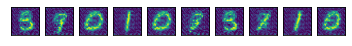

Epoch: [88] [  50/ 200] D_loss: 2.01838970, G_loss: 0.75996119
Epoch: [88] [ 100/ 200] D_loss: 2.28875780, G_loss: 0.58720922
Epoch: [88] [ 150/ 200] D_loss: 1.67843187, G_loss: 0.76009047
Epoch: [88] [ 200/ 200] D_loss: 3.92823839, G_loss: 0.77469707


<Figure size 72x720 with 0 Axes>

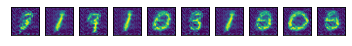

Epoch: [89] [  50/ 200] D_loss: 1.92542553, G_loss: 0.70956933
Epoch: [89] [ 100/ 200] D_loss: 5.50171280, G_loss: 0.85279256
Epoch: [89] [ 150/ 200] D_loss: 5.14875603, G_loss: 0.77175701
Epoch: [89] [ 200/ 200] D_loss: 1.13630843, G_loss: 0.67814720


<Figure size 72x720 with 0 Axes>

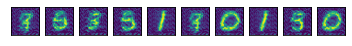

Epoch: [90] [  50/ 200] D_loss: 1.34424627, G_loss: 0.86431044
Epoch: [90] [ 100/ 200] D_loss: 1.68934047, G_loss: 0.70522994
Epoch: [90] [ 150/ 200] D_loss: 1.57567823, G_loss: 0.74763596
Epoch: [90] [ 200/ 200] D_loss: 1.62908900, G_loss: 0.81439316


<Figure size 72x720 with 0 Axes>

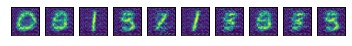

Epoch: [91] [  50/ 200] D_loss: 2.26859903, G_loss: 0.79662395
Epoch: [91] [ 100/ 200] D_loss: 1.98411512, G_loss: 0.85819405
Epoch: [91] [ 150/ 200] D_loss: 1.66630137, G_loss: 0.84356636
Epoch: [91] [ 200/ 200] D_loss: 1.50893164, G_loss: 0.86858314
Training at Epoch:
90


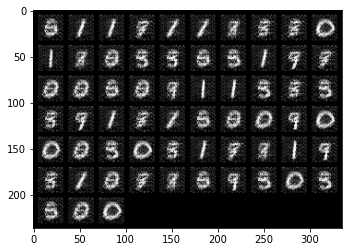

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000,  9.2124,  0.0000, 10.4133,  0.0000,  0.0000,
          8.0619,  5.7485],
        [ 0.0000,  0.0000,  1.4524,  8.7507,  0.0000,  1.6293,  0.0000,  0.0000,
         10.8704,  0.0000],
        [ 0.0000, 27.3991,  5.6562,  0.0000,  0.0000,  0.0000,  0.0000,  7.6335,
          0.0000,  0.0000],
        [ 0.0000, 22.4624,  8.8167,  0.0000,  0.0000,  0.0000,  0.0000,  3.5294,
          0.0000,  0.0000],
        [24.5656,  0.0000,  4.8337,  0.0000,  0.0000,  0.0000,  3.7071,  0.0000,
          0.0000,  0.0000],
        [16.1131,  0.0000, 10.3158,  0.0000,  0.0000,  0.0000,  1.3827,  0.0000,
          0.6163,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.8498,  0.0000,  0.0000, 12.8392,
          0.0000, 17.5651],
        [ 0.0000,  0.0000,  0.0000,  8.7250,  0.0000, 10.2393,  0.0000,  0.0000,
          7.9789,  6.0104],
        [ 0.0000,  0.0000,  0.0000,  2.2910,  1.0817,  0.0000,  0.0000,  8.1183,
          0.00

<Figure size 72x720 with 0 Axes>

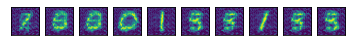

Epoch: [92] [  50/ 200] D_loss: 1.48948205, G_loss: 0.84857625
Epoch: [92] [ 100/ 200] D_loss: 1.50443029, G_loss: 0.77861965
Epoch: [92] [ 150/ 200] D_loss: 1.47171879, G_loss: 0.85332525
Epoch: [92] [ 200/ 200] D_loss: 2.46843719, G_loss: 0.82388878


<Figure size 72x720 with 0 Axes>

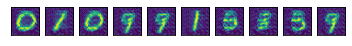

Epoch: [93] [  50/ 200] D_loss: 9.18432045, G_loss: 0.70239180
Epoch: [93] [ 100/ 200] D_loss: 1.57890165, G_loss: 0.88938528
Epoch: [93] [ 150/ 200] D_loss: 1.14729989, G_loss: 0.74867797
Epoch: [93] [ 200/ 200] D_loss: 2.03240347, G_loss: 0.74858493


<Figure size 72x720 with 0 Axes>

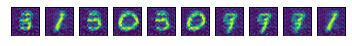

Epoch: [94] [  50/ 200] D_loss: 1.31991744, G_loss: 0.84029728
Epoch: [94] [ 100/ 200] D_loss: 3.04209089, G_loss: 0.81092197
Epoch: [94] [ 150/ 200] D_loss: 1.14444423, G_loss: 0.79094440
Epoch: [94] [ 200/ 200] D_loss: 1.79571211, G_loss: 0.92960000


<Figure size 72x720 with 0 Axes>

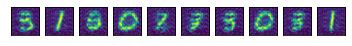

Epoch: [95] [  50/ 200] D_loss: 1.66337168, G_loss: 0.62076366
Epoch: [95] [ 100/ 200] D_loss: 1.27226567, G_loss: 0.88056290
Epoch: [95] [ 150/ 200] D_loss: 1.08581984, G_loss: 0.80688661
Epoch: [95] [ 200/ 200] D_loss: 1.48263204, G_loss: 0.72731662


<Figure size 72x720 with 0 Axes>

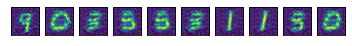

Epoch: [96] [  50/ 200] D_loss: 1.46284103, G_loss: 0.88407600
Epoch: [96] [ 100/ 200] D_loss: 1.42014420, G_loss: 0.81974608
Epoch: [96] [ 150/ 200] D_loss: 1.30684984, G_loss: 0.84183443
Epoch: [96] [ 200/ 200] D_loss: 1.65193319, G_loss: 0.88756371


<Figure size 72x720 with 0 Axes>

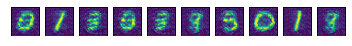

Epoch: [97] [  50/ 200] D_loss: 1.60252857, G_loss: 0.71459574
Epoch: [97] [ 100/ 200] D_loss: 1.16239083, G_loss: 0.83216679
Epoch: [97] [ 150/ 200] D_loss: 1.47406352, G_loss: 0.64153683
Epoch: [97] [ 200/ 200] D_loss: 1.94862199, G_loss: 0.86963660


<Figure size 72x720 with 0 Axes>

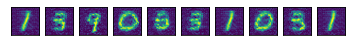

Epoch: [98] [  50/ 200] D_loss: 2.14844346, G_loss: 0.83149725
Epoch: [98] [ 100/ 200] D_loss: 1.45052195, G_loss: 0.71890002
Epoch: [98] [ 150/ 200] D_loss: 1.63339651, G_loss: 0.82104343
Epoch: [98] [ 200/ 200] D_loss: 1.59620965, G_loss: 0.59628779


<Figure size 72x720 with 0 Axes>

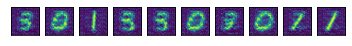

Epoch: [99] [  50/ 200] D_loss: 8.10181236, G_loss: 0.75120938
Epoch: [99] [ 100/ 200] D_loss: 1.67813253, G_loss: 0.75236517
Epoch: [99] [ 150/ 200] D_loss: 2.85368371, G_loss: 0.83625501
Epoch: [99] [ 200/ 200] D_loss: 2.02456594, G_loss: 0.85191250


<Figure size 72x720 with 0 Axes>

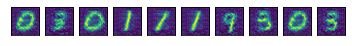

Epoch: [100] [  50/ 200] D_loss: 1.96711278, G_loss: 0.85514289
Epoch: [100] [ 100/ 200] D_loss: 1.55930316, G_loss: 0.81868082
Epoch: [100] [ 150/ 200] D_loss: 4.00789404, G_loss: 0.75966275
Epoch: [100] [ 200/ 200] D_loss: 1.86353087, G_loss: 0.81427073


<Figure size 72x720 with 0 Axes>

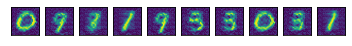

Epoch: [101] [  50/ 200] D_loss: 1.93323421, G_loss: 0.82507640
Epoch: [101] [ 100/ 200] D_loss: 1.92622733, G_loss: 0.86350828
Epoch: [101] [ 150/ 200] D_loss: 1.81444359, G_loss: 0.89843148
Epoch: [101] [ 200/ 200] D_loss: 1.07859051, G_loss: 0.78106982
Training at Epoch:
100


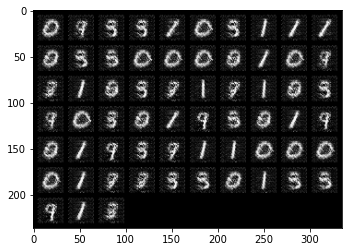

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000, 17.5258,  0.0000,  0.0000,  2.4705,  0.0000,  0.0000,  7.1060,
          0.0000,  0.0000],
        [ 0.0000, 11.7518,  7.9402,  0.3151,  0.0000,  0.0000,  0.0000,  3.0272,
          0.0000,  0.0000],
        [ 0.0000, 23.1916,  0.0000,  0.0000,  6.2862,  0.0000,  0.0000,  3.9643,
          0.0000,  0.0000],
        [ 0.0000, 16.1151,  6.0234,  0.0000,  0.0000,  0.0000,  0.0000,  4.6645,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  3.5850,  0.0000,  0.0000,  0.0000,  1.1128,
         13.8093, 13.8209],
        [ 0.0000,  0.0000,  0.0000, 18.7616,  0.0000, 14.0962,  0.0000,  0.0000,
         10.1880,  7.1520],
        [21.4173,  0.0000,  5.2241,  0.0000,  0.0000,  0.0000,  2.1610,  0.0000,
          0.0000,  3.1282],
        [22.3591,  0.0000,  5.5575,  0.0000,  0.0000,  0.0000,  1.7431,  0.0000,
          0.0000,  1.1620],
        [ 0.0000, 14.4134,  6.4678,  0.0000,  0.0000,  0.0000,  0.0000,  3.6846,
          0.00

<Figure size 72x720 with 0 Axes>

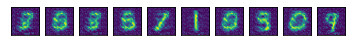

Epoch: [102] [  50/ 200] D_loss: 2.24008560, G_loss: 0.80328572
Epoch: [102] [ 100/ 200] D_loss: 2.74242544, G_loss: 0.87805063
Epoch: [102] [ 150/ 200] D_loss: 1.89456999, G_loss: 0.93993968
Epoch: [102] [ 200/ 200] D_loss: 1.25569987, G_loss: 0.94481373


<Figure size 72x720 with 0 Axes>

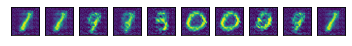

Epoch: [103] [  50/ 200] D_loss: 1.47544754, G_loss: 0.86599290
Epoch: [103] [ 100/ 200] D_loss: 1.68894029, G_loss: 0.90772587
Epoch: [103] [ 150/ 200] D_loss: 1.32435656, G_loss: 0.86060774
Epoch: [103] [ 200/ 200] D_loss: 1.78483891, G_loss: 0.74636245


<Figure size 72x720 with 0 Axes>

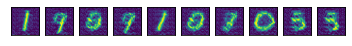

Epoch: [104] [  50/ 200] D_loss: 2.00258350, G_loss: 0.80807883
Epoch: [104] [ 100/ 200] D_loss: 2.87738872, G_loss: 0.86388165
Epoch: [104] [ 150/ 200] D_loss: 2.14348221, G_loss: 0.85772157
Epoch: [104] [ 200/ 200] D_loss: 2.16446662, G_loss: 0.82181394


<Figure size 72x720 with 0 Axes>

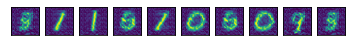

Epoch: [105] [  50/ 200] D_loss: 1.59361029, G_loss: 0.84915680
Epoch: [105] [ 100/ 200] D_loss: 2.48129058, G_loss: 0.89606047
Epoch: [105] [ 150/ 200] D_loss: 2.38019896, G_loss: 0.91871673
Epoch: [105] [ 200/ 200] D_loss: 1.49196875, G_loss: 0.90428776


<Figure size 72x720 with 0 Axes>

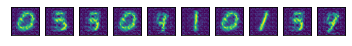

Epoch: [106] [  50/ 200] D_loss: 1.90260327, G_loss: 0.91987729
Epoch: [106] [ 100/ 200] D_loss: 2.14029455, G_loss: 0.81113607
Epoch: [106] [ 150/ 200] D_loss: 1.65469038, G_loss: 0.75566238
Epoch: [106] [ 200/ 200] D_loss: 1.73743486, G_loss: 0.91127247


<Figure size 72x720 with 0 Axes>

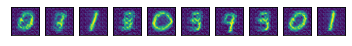

Epoch: [107] [  50/ 200] D_loss: 1.55263770, G_loss: 0.85491472
Epoch: [107] [ 100/ 200] D_loss: 1.98862243, G_loss: 0.81200176
Epoch: [107] [ 150/ 200] D_loss: 2.71585035, G_loss: 0.91516924
Epoch: [107] [ 200/ 200] D_loss: 1.58029521, G_loss: 0.91494185


<Figure size 72x720 with 0 Axes>

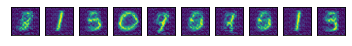

Epoch: [108] [  50/ 200] D_loss: 2.33109474, G_loss: 0.73564243
Epoch: [108] [ 100/ 200] D_loss: 1.71163690, G_loss: 0.87246096
Epoch: [108] [ 150/ 200] D_loss: 2.42804050, G_loss: 0.92412162
Epoch: [108] [ 200/ 200] D_loss: 2.48340940, G_loss: 0.92196852


<Figure size 72x720 with 0 Axes>

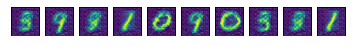

Epoch: [109] [  50/ 200] D_loss: 2.11897039, G_loss: 0.92435211
Epoch: [109] [ 100/ 200] D_loss: 2.53932500, G_loss: 0.91349202
Epoch: [109] [ 150/ 200] D_loss: 1.84396136, G_loss: 0.86303824
Epoch: [109] [ 200/ 200] D_loss: 1.34092772, G_loss: 0.84972388


<Figure size 72x720 with 0 Axes>

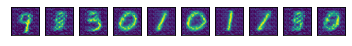

Epoch: [110] [  50/ 200] D_loss: 2.90729809, G_loss: 0.83344549
Epoch: [110] [ 100/ 200] D_loss: 2.43007207, G_loss: 0.86969060
Epoch: [110] [ 150/ 200] D_loss: 2.50010395, G_loss: 0.77372736
Epoch: [110] [ 200/ 200] D_loss: 3.44723678, G_loss: 0.92069060


<Figure size 72x720 with 0 Axes>

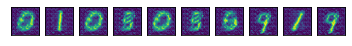

Epoch: [111] [  50/ 200] D_loss: 2.05295038, G_loss: 0.84018874
Epoch: [111] [ 100/ 200] D_loss: 1.88708615, G_loss: 0.88196450
Epoch: [111] [ 150/ 200] D_loss: 1.53467059, G_loss: 0.82233906
Epoch: [111] [ 200/ 200] D_loss: 1.54724431, G_loss: 0.75862169
Training at Epoch:
110


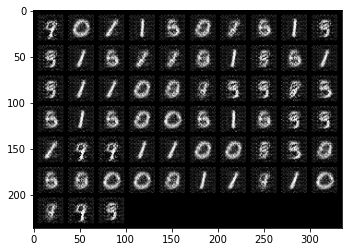

outputs:  torch.Size([10, 10])
	 tensor([[20.2623,  0.0000,  1.0898,  0.0000,  0.0000,  0.0000,  1.5416,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  5.2487,  0.0000,  0.0000,  6.7208,
          0.0000, 15.8272],
        [ 0.0000, 24.9835, 10.7032,  0.0000,  0.0000,  0.0000,  0.0000,  5.7562,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.2972,  0.0000,  0.0000,  5.7344,
          1.4959, 15.3756],
        [ 0.0000, 25.6455,  8.1731,  0.0000,  0.0000,  0.0000,  0.0000,  6.9147,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  9.4311,  0.0000,  0.0000,  8.0853,
          0.0000, 16.0333],
        [19.5944,  0.0000,  4.1169,  0.0000,  0.0000,  0.0000,  0.6214,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  6.7855,  8.2152,  0.0000,  0.0000,  5.3305,  0.0000,
         25.8028,  0.0000],
        [20.0957,  0.0000,  1.9715,  0.0000,  0.0000,  0.0000,  1.2798,  0.0000,
          0.00

<Figure size 72x720 with 0 Axes>

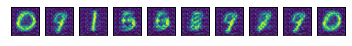

Epoch: [112] [  50/ 200] D_loss: 2.89864826, G_loss: 0.90698576
Epoch: [112] [ 100/ 200] D_loss: 1.99549770, G_loss: 0.90023857
Epoch: [112] [ 150/ 200] D_loss: 2.27254415, G_loss: 0.81079155
Epoch: [112] [ 200/ 200] D_loss: 2.03586125, G_loss: 0.89458263


<Figure size 72x720 with 0 Axes>

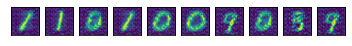

Epoch: [113] [  50/ 200] D_loss: 2.62480736, G_loss: 0.90763450
Epoch: [113] [ 100/ 200] D_loss: 1.61966610, G_loss: 0.87166643
Epoch: [113] [ 150/ 200] D_loss: 2.33217597, G_loss: 0.75189084
Epoch: [113] [ 200/ 200] D_loss: 2.16202021, G_loss: 0.85794014


<Figure size 72x720 with 0 Axes>

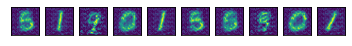

Epoch: [114] [  50/ 200] D_loss: 2.19811916, G_loss: 0.78087640
Epoch: [114] [ 100/ 200] D_loss: 2.02300668, G_loss: 0.86119252
Epoch: [114] [ 150/ 200] D_loss: 2.32550073, G_loss: 0.91665345
Epoch: [114] [ 200/ 200] D_loss: 2.29098892, G_loss: 0.94593149


<Figure size 72x720 with 0 Axes>

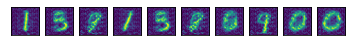

Epoch: [115] [  50/ 200] D_loss: 2.34245849, G_loss: 0.88899469
Epoch: [115] [ 100/ 200] D_loss: 2.77694488, G_loss: 0.77334028
Epoch: [115] [ 150/ 200] D_loss: 2.07056856, G_loss: 0.89101750
Epoch: [115] [ 200/ 200] D_loss: 4.17005539, G_loss: 0.81576806


<Figure size 72x720 with 0 Axes>

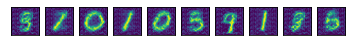

Epoch: [116] [  50/ 200] D_loss: 2.80697012, G_loss: 0.93184304
Epoch: [116] [ 100/ 200] D_loss: 2.73235607, G_loss: 0.67238712
Epoch: [116] [ 150/ 200] D_loss: 2.28556156, G_loss: 0.73537767
Epoch: [116] [ 200/ 200] D_loss: 0.87415719, G_loss: 0.50738376


<Figure size 72x720 with 0 Axes>

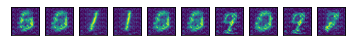

Epoch: [117] [  50/ 200] D_loss: 1.75800097, G_loss: 0.88888907
Epoch: [117] [ 100/ 200] D_loss: 2.98676181, G_loss: 0.72112811
Epoch: [117] [ 150/ 200] D_loss: 1.87411940, G_loss: 0.87636703
Epoch: [117] [ 200/ 200] D_loss: 1.78937078, G_loss: 0.90775025


<Figure size 72x720 with 0 Axes>

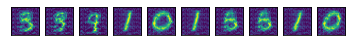

Epoch: [118] [  50/ 200] D_loss: 2.29427099, G_loss: 0.91745126
Epoch: [118] [ 100/ 200] D_loss: 2.09717751, G_loss: 0.88549930
Epoch: [118] [ 150/ 200] D_loss: 2.65031219, G_loss: 0.81706309
Epoch: [118] [ 200/ 200] D_loss: 3.40603280, G_loss: 0.89465731


<Figure size 72x720 with 0 Axes>

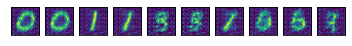

Epoch: [119] [  50/ 200] D_loss: 2.49848127, G_loss: 0.90355027
Epoch: [119] [ 100/ 200] D_loss: 2.74715495, G_loss: 0.91799301
Epoch: [119] [ 150/ 200] D_loss: 3.17095447, G_loss: 0.81923079
Epoch: [119] [ 200/ 200] D_loss: 3.19791794, G_loss: 0.83291173


<Figure size 72x720 with 0 Axes>

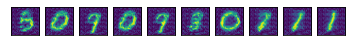

Epoch: [120] [  50/ 200] D_loss: 1.95618987, G_loss: 0.88648164
Epoch: [120] [ 100/ 200] D_loss: 1.91143632, G_loss: 0.81480056
Epoch: [120] [ 150/ 200] D_loss: 2.11896658, G_loss: 0.94020802
Epoch: [120] [ 200/ 200] D_loss: 2.08485007, G_loss: 0.89163893


<Figure size 72x720 with 0 Axes>

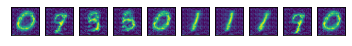

Epoch: [121] [  50/ 200] D_loss: 2.38745785, G_loss: 0.91511226
Epoch: [121] [ 100/ 200] D_loss: 3.10785532, G_loss: 0.85314149
Epoch: [121] [ 150/ 200] D_loss: 2.04379749, G_loss: 0.88969946
Epoch: [121] [ 200/ 200] D_loss: 2.71434665, G_loss: 0.95095301
Training at Epoch:
120


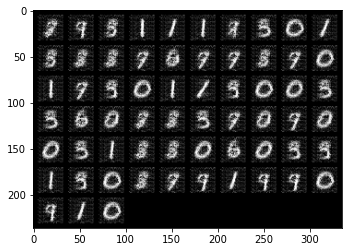

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000, 16.6971,  0.0000,  2.8013,  0.0000,  0.0000,
          5.8596,  7.4984],
        [ 9.5692,  0.0000,  7.7729,  0.0000,  0.0000,  0.0000,  7.4703,  0.0000,
          1.2584,  0.0000],
        [21.7043,  0.0000,  8.0254,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [26.0605,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  3.0092,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.6868,  8.7033,  0.0000,  0.0000,  0.2928,  0.0000,
         16.3665,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  5.5293,  0.0000,  0.0000, 19.3852,
          0.0000,  8.1123],
        [ 0.0000,  1.8369,  0.0000,  0.0000,  3.9854,  0.0000,  0.0000, 15.7825,
          0.0000,  7.0735],
        [ 0.0000,  0.0000,  0.0000, 13.2454,  0.0000,  4.4034,  0.0000,  0.0000,
          7.3118,  9.2972],
        [ 0.0000,  0.0000,  1.9861,  2.7922,  0.0000,  0.0000,  0.0000,  6.1350,
          6.20

<Figure size 72x720 with 0 Axes>

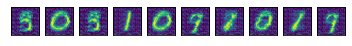

Epoch: [122] [  50/ 200] D_loss: 2.50800943, G_loss: 0.85884202
Epoch: [122] [ 100/ 200] D_loss: 3.06089187, G_loss: 0.88519371
Epoch: [122] [ 150/ 200] D_loss: 2.14017558, G_loss: 0.83605826
Epoch: [122] [ 200/ 200] D_loss: 2.02820420, G_loss: 0.91919512


<Figure size 72x720 with 0 Axes>

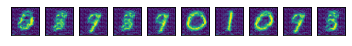

Epoch: [123] [  50/ 200] D_loss: 5.92100716, G_loss: 0.89975959
Epoch: [123] [ 100/ 200] D_loss: 1.95953178, G_loss: 0.93007797
Epoch: [123] [ 150/ 200] D_loss: 1.96215534, G_loss: 0.81135345
Epoch: [123] [ 200/ 200] D_loss: 2.73777270, G_loss: 0.94255280


<Figure size 72x720 with 0 Axes>

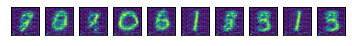

Epoch: [124] [  50/ 200] D_loss: 1.47274375, G_loss: 0.81145883
Epoch: [124] [ 100/ 200] D_loss: 10.00944328, G_loss: 0.89848512
Epoch: [124] [ 150/ 200] D_loss: 2.48379850, G_loss: 0.87971127
Epoch: [124] [ 200/ 200] D_loss: 3.81602430, G_loss: 0.92900521


<Figure size 72x720 with 0 Axes>

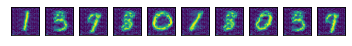

Epoch: [125] [  50/ 200] D_loss: 2.11504674, G_loss: 0.90256739
Epoch: [125] [ 100/ 200] D_loss: 2.66607356, G_loss: 0.84363753
Epoch: [125] [ 150/ 200] D_loss: 3.27010131, G_loss: 0.86103547
Epoch: [125] [ 200/ 200] D_loss: 2.64868116, G_loss: 0.82677978


<Figure size 72x720 with 0 Axes>

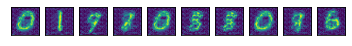

Epoch: [126] [  50/ 200] D_loss: 2.32032323, G_loss: 0.94566071
Epoch: [126] [ 100/ 200] D_loss: 3.03718352, G_loss: 0.89538532
Epoch: [126] [ 150/ 200] D_loss: 4.08447695, G_loss: 0.84753412
Epoch: [126] [ 200/ 200] D_loss: 4.49598789, G_loss: 0.82315564


<Figure size 72x720 with 0 Axes>

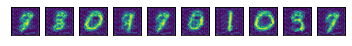

Epoch: [127] [  50/ 200] D_loss: 3.16289759, G_loss: 0.87006348
Epoch: [127] [ 100/ 200] D_loss: 2.60151339, G_loss: 0.79818964
Epoch: [127] [ 150/ 200] D_loss: 5.30026627, G_loss: 0.88184541
Epoch: [127] [ 200/ 200] D_loss: 3.01538634, G_loss: 0.82505733


<Figure size 72x720 with 0 Axes>

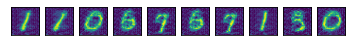

Epoch: [128] [  50/ 200] D_loss: 1.49547148, G_loss: 0.93215400
Epoch: [128] [ 100/ 200] D_loss: 2.21549106, G_loss: 0.95364374
Epoch: [128] [ 150/ 200] D_loss: 2.09310722, G_loss: 0.85641420
Epoch: [128] [ 200/ 200] D_loss: 2.55435252, G_loss: 0.76805383


<Figure size 72x720 with 0 Axes>

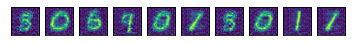

Epoch: [129] [  50/ 200] D_loss: 2.15976906, G_loss: 0.89096153
Epoch: [129] [ 100/ 200] D_loss: 7.67320824, G_loss: 0.76478416
Epoch: [129] [ 150/ 200] D_loss: 4.03126669, G_loss: 0.90444803
Epoch: [129] [ 200/ 200] D_loss: 2.93258977, G_loss: 0.89624834


<Figure size 72x720 with 0 Axes>

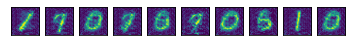

Epoch: [130] [  50/ 200] D_loss: 2.08256841, G_loss: 0.84943205
Epoch: [130] [ 100/ 200] D_loss: 2.49476457, G_loss: 0.94603360
Epoch: [130] [ 150/ 200] D_loss: 2.48964190, G_loss: 0.81814754
Epoch: [130] [ 200/ 200] D_loss: 2.19879341, G_loss: 0.79686564


<Figure size 72x720 with 0 Axes>

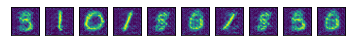

Epoch: [131] [  50/ 200] D_loss: 16.86607361, G_loss: 0.71863896
Epoch: [131] [ 100/ 200] D_loss: 2.45456505, G_loss: 0.76552671
Epoch: [131] [ 150/ 200] D_loss: 1.71471953, G_loss: 0.88554746
Epoch: [131] [ 200/ 200] D_loss: 2.79297090, G_loss: 0.87279797
Training at Epoch:
130


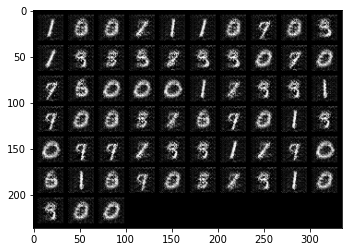

outputs:  torch.Size([10, 10])
	 tensor([[14.6839,  0.0000,  7.0433,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.8576],
        [ 0.0000, 26.3753,  7.6679,  0.0000,  0.0000,  0.0000,  0.0000,  6.2333,
          0.0000,  0.0000],
        [15.2263,  0.0000,  6.9878,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.8271],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  5.2737,  0.0000,  0.0000, 21.5472,
          0.0000, 13.7466],
        [11.6370,  0.0000,  6.2261,  0.0000,  0.0000,  0.0000,  2.2659,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 30.6983,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  7.1202,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 17.4296,  0.0000,  7.4597,  0.0000,  0.0000,
         11.5457, 11.1324],
        [ 0.0000,  0.0000,  0.0000,  3.4677,  0.0000, 13.0650, 12.2108,  0.0000,
          1.8463,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 16.0275,  0.0000,  7.1244,  0.0000,  0.0000,
         11.03

<Figure size 72x720 with 0 Axes>

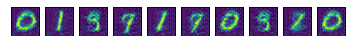

Epoch: [132] [  50/ 200] D_loss: 2.63412499, G_loss: 0.89106816
Epoch: [132] [ 100/ 200] D_loss: 1.44800460, G_loss: 0.89107472
Epoch: [132] [ 150/ 200] D_loss: 1.76489377, G_loss: 0.89066380
Epoch: [132] [ 200/ 200] D_loss: 2.79344487, G_loss: 0.55012727


<Figure size 72x720 with 0 Axes>

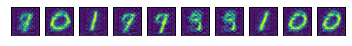

Epoch: [133] [  50/ 200] D_loss: 2.41488695, G_loss: 0.67367470
Epoch: [133] [ 100/ 200] D_loss: 2.78139639, G_loss: 0.89793968
Epoch: [133] [ 150/ 200] D_loss: 1.97567034, G_loss: 0.94490796
Epoch: [133] [ 200/ 200] D_loss: 1.52489722, G_loss: 0.88617551


<Figure size 72x720 with 0 Axes>

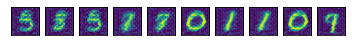

Epoch: [134] [  50/ 200] D_loss: 2.33726287, G_loss: 0.93551648
Epoch: [134] [ 100/ 200] D_loss: 2.85496688, G_loss: 0.80273443
Epoch: [134] [ 150/ 200] D_loss: 30.18102646, G_loss: 0.82857126
Epoch: [134] [ 200/ 200] D_loss: 2.53798604, G_loss: 0.84998459


<Figure size 72x720 with 0 Axes>

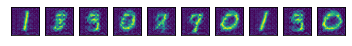

Epoch: [135] [  50/ 200] D_loss: 2.72254181, G_loss: 0.83750093
Epoch: [135] [ 100/ 200] D_loss: 2.39825487, G_loss: 0.92101860
Epoch: [135] [ 150/ 200] D_loss: 2.33871794, G_loss: 0.91800588
Epoch: [135] [ 200/ 200] D_loss: 2.12192416, G_loss: 0.89626688


<Figure size 72x720 with 0 Axes>

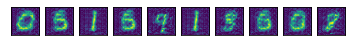

Epoch: [136] [  50/ 200] D_loss: 2.75245309, G_loss: 0.89431232
Epoch: [136] [ 100/ 200] D_loss: 1.48387957, G_loss: 0.85367227
Epoch: [136] [ 150/ 200] D_loss: 2.02764773, G_loss: 0.84170675
Epoch: [136] [ 200/ 200] D_loss: 2.60431671, G_loss: 0.87795496


<Figure size 72x720 with 0 Axes>

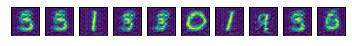

Epoch: [137] [  50/ 200] D_loss: 2.71844769, G_loss: 0.88817906
Epoch: [137] [ 100/ 200] D_loss: 2.64023638, G_loss: 0.94470233
Epoch: [137] [ 150/ 200] D_loss: 1.85347450, G_loss: 0.91783309
Epoch: [137] [ 200/ 200] D_loss: 2.70656681, G_loss: 0.83076411


<Figure size 72x720 with 0 Axes>

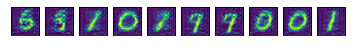

Epoch: [138] [  50/ 200] D_loss: 2.65951943, G_loss: 0.88896841
Epoch: [138] [ 100/ 200] D_loss: 2.73992181, G_loss: 0.84656030
Epoch: [138] [ 150/ 200] D_loss: 2.08741164, G_loss: 0.87950343
Epoch: [138] [ 200/ 200] D_loss: 2.51662469, G_loss: 0.88750982


<Figure size 72x720 with 0 Axes>

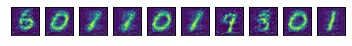

Epoch: [139] [  50/ 200] D_loss: 4.54207420, G_loss: 0.79131877
Epoch: [139] [ 100/ 200] D_loss: 2.72412491, G_loss: 0.86850017
Epoch: [139] [ 150/ 200] D_loss: 3.43590951, G_loss: 0.81953251
Epoch: [139] [ 200/ 200] D_loss: 2.53553343, G_loss: 0.95553559


<Figure size 72x720 with 0 Axes>

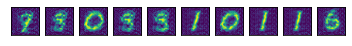

Epoch: [140] [  50/ 200] D_loss: 1.81134379, G_loss: 0.73972440
Epoch: [140] [ 100/ 200] D_loss: 2.30646515, G_loss: 0.86673957
Epoch: [140] [ 150/ 200] D_loss: 2.75268221, G_loss: 0.89618599
Epoch: [140] [ 200/ 200] D_loss: 3.59815335, G_loss: 0.90877813


<Figure size 72x720 with 0 Axes>

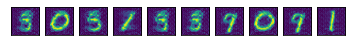

Epoch: [141] [  50/ 200] D_loss: 1.95943856, G_loss: 0.91149920
Epoch: [141] [ 100/ 200] D_loss: 3.14758134, G_loss: 0.92950457
Epoch: [141] [ 150/ 200] D_loss: 2.00772429, G_loss: 0.78551519
Epoch: [141] [ 200/ 200] D_loss: 2.76209235, G_loss: 0.89224690
Training at Epoch:
140


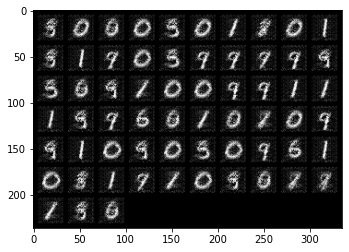

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000,  8.8785,  0.0000, 10.0723,  0.0000,  0.0000,
         18.9802, 19.9817],
        [ 0.0000,  0.9781, 15.7343,  2.6209,  0.0000,  0.0000,  0.0000,  0.0000,
          6.0947,  0.0000],
        [ 0.0000, 27.7609,  0.0000,  0.0000,  0.9095,  0.0000,  0.0000,  4.6135,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  6.4136,  1.3106,  0.0000,  9.7936,
          0.0000, 17.9319],
        [ 0.0000, 18.4762,  0.0000,  0.5675,  0.0000,  0.0000,  0.0000,  6.8866,
          0.0000,  0.0000],
        [ 0.0000,  9.4454, 11.0640,  0.0000,  0.0000,  0.0000,  0.0000,  1.6686,
          0.0000,  0.0000],
        [21.5536,  0.0000,  3.3161,  0.0000,  0.0000,  0.0000,  2.3860,  0.0000,
          0.0000,  0.0000],
        [12.7769,  0.0000,  5.2818,  0.0000,  0.0000,  0.0000,  3.8396,  0.0000,
          4.5533,  3.2356],
        [ 0.0000,  0.0000,  0.0000,  2.6944,  2.2281,  3.8974,  0.0000,  4.8325,
          0.00

<Figure size 72x720 with 0 Axes>

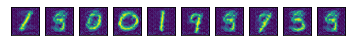

Epoch: [142] [  50/ 200] D_loss: 2.52221012, G_loss: 0.89958608
Epoch: [142] [ 100/ 200] D_loss: 2.65965819, G_loss: 0.91201878
Epoch: [142] [ 150/ 200] D_loss: 4.66159630, G_loss: 0.90016055
Epoch: [142] [ 200/ 200] D_loss: 2.85111856, G_loss: 0.87685919


<Figure size 72x720 with 0 Axes>

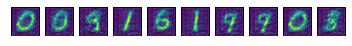

Epoch: [143] [  50/ 200] D_loss: 1.67651606, G_loss: 0.84523314
Epoch: [143] [ 100/ 200] D_loss: 2.30865788, G_loss: 0.63790739
Epoch: [143] [ 150/ 200] D_loss: 3.07517076, G_loss: 0.87210262
Epoch: [143] [ 200/ 200] D_loss: 1.79260159, G_loss: 0.82506686


<Figure size 72x720 with 0 Axes>

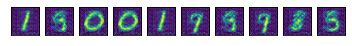

Epoch: [144] [  50/ 200] D_loss: 1.88521743, G_loss: 0.67810977
Epoch: [144] [ 100/ 200] D_loss: 1.87794793, G_loss: 0.87995821
Epoch: [144] [ 150/ 200] D_loss: 2.82559109, G_loss: 0.87135887
Epoch: [144] [ 200/ 200] D_loss: 3.50560904, G_loss: 0.83011615


<Figure size 72x720 with 0 Axes>

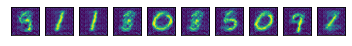

Epoch: [145] [  50/ 200] D_loss: 2.75805640, G_loss: 0.90284425
Epoch: [145] [ 100/ 200] D_loss: 1.83386612, G_loss: 0.84255213
Epoch: [145] [ 150/ 200] D_loss: 2.46031880, G_loss: 0.90183294
Epoch: [145] [ 200/ 200] D_loss: 3.03741193, G_loss: 0.89955306


<Figure size 72x720 with 0 Axes>

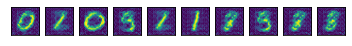

Epoch: [146] [  50/ 200] D_loss: 1.60289025, G_loss: 0.91726911
Epoch: [146] [ 100/ 200] D_loss: 3.08190799, G_loss: 0.88480699
Epoch: [146] [ 150/ 200] D_loss: 2.88898849, G_loss: 0.78684026
Epoch: [146] [ 200/ 200] D_loss: 1.55988324, G_loss: 0.84055316


<Figure size 72x720 with 0 Axes>

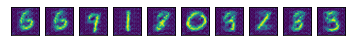

Epoch: [147] [  50/ 200] D_loss: 7.63918114, G_loss: 0.88369596
Epoch: [147] [ 100/ 200] D_loss: 2.70395899, G_loss: 0.88810128
Epoch: [147] [ 150/ 200] D_loss: 2.19475389, G_loss: 0.93256521
Epoch: [147] [ 200/ 200] D_loss: 2.21120644, G_loss: 0.79704082


<Figure size 72x720 with 0 Axes>

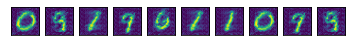

Epoch: [148] [  50/ 200] D_loss: 1.74310768, G_loss: 0.82189023
Epoch: [148] [ 100/ 200] D_loss: 2.21670890, G_loss: 0.87068379
Epoch: [148] [ 150/ 200] D_loss: 2.88243771, G_loss: 0.47395325
Epoch: [148] [ 200/ 200] D_loss: 2.07038927, G_loss: 0.89688331


<Figure size 72x720 with 0 Axes>

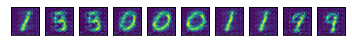

Epoch: [149] [  50/ 200] D_loss: 4.77638865, G_loss: 0.79333913
Epoch: [149] [ 100/ 200] D_loss: 2.18052626, G_loss: 0.89383882
Epoch: [149] [ 150/ 200] D_loss: 2.67433453, G_loss: 0.76754248
Epoch: [149] [ 200/ 200] D_loss: 2.55448890, G_loss: 0.78577942


<Figure size 72x720 with 0 Axes>

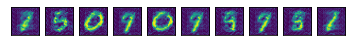

Epoch: [150] [  50/ 200] D_loss: 2.31413937, G_loss: 0.76667464
Epoch: [150] [ 100/ 200] D_loss: 1.73142421, G_loss: 0.91408640
Epoch: [150] [ 150/ 200] D_loss: 4.18738651, G_loss: 0.72952580
Epoch: [150] [ 200/ 200] D_loss: 2.22122955, G_loss: 0.85643274


<Figure size 72x720 with 0 Axes>

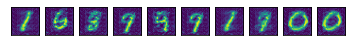

Training finished!


In [15]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':150}

params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)


gan.train()

1
training start!!
Epoch: [ 1] [  50/ 200] D_loss: 8.70215321, G_loss: 0.01471591
Epoch: [ 1] [ 100/ 200] D_loss: 9.56772137, G_loss: 0.02262133
Epoch: [ 1] [ 150/ 200] D_loss: 6.74544048, G_loss: 0.02390569
Epoch: [ 1] [ 200/ 200] D_loss: 2.61930990, G_loss: 0.01381367
Training at Epoch:
0


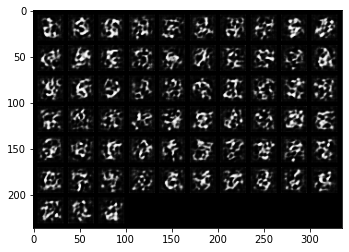

outputs:  torch.Size([10, 10])
	 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, 16.0026,  0.0000,  0.0000,  0.0000,
          0.5956,  4.0306],
        [ 0.0000,  0.0000,  0.0000, 12.0371,  0.0000,  0.0000,  0.0000,  5.0603,
          0.0000, 17.4699],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.5261,  1.7020,  2.0244,  0.0000,
          5.8167,  0.5951],
        [ 0.0000,  0.0000,  5.4528,  3.3549,  0.0000,  3.9301,  4.8822,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  9.1283,  0.0000,  7.0084,  0.0000,  0.0000,
          1.6917,  1.4269],
        [ 0.0000,  0.0000,  2.7362,  8.3985,  0.0000,  0.0000,  0.3103,  0.0000,
          0.0000,  0.0000],
        [ 0.0000, 12.2787,  4.3315,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          5.5543,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.6507,  0.0000, 16.9976,
          0.0000,  0.0000],
        [ 5.3469,  8.2193,  7.9962,  0.0000,  0.0000,  0.0000,  3.2241,  0.0000,
          7.88

<Figure size 72x720 with 0 Axes>

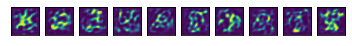

Epoch: [ 2] [  50/ 200] D_loss: 2.56697798, G_loss: 0.02055365
Epoch: [ 2] [ 100/ 200] D_loss: 4.06705809, G_loss: 0.03919536
Epoch: [ 2] [ 150/ 200] D_loss: 4.01819563, G_loss: 0.02210462
Epoch: [ 2] [ 200/ 200] D_loss: 4.02318335, G_loss: 0.02333844


<Figure size 72x720 with 0 Axes>

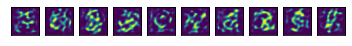

Epoch: [ 3] [  50/ 200] D_loss: 3.28257728, G_loss: 0.02660525
Epoch: [ 3] [ 100/ 200] D_loss: 7.40014839, G_loss: 0.02480847
Epoch: [ 3] [ 150/ 200] D_loss: 5.54199123, G_loss: 0.02494133
Epoch: [ 3] [ 200/ 200] D_loss: 5.45711470, G_loss: 0.02410632


<Figure size 72x720 with 0 Axes>

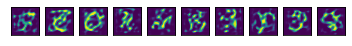

Epoch: [ 4] [  50/ 200] D_loss: 3.93752384, G_loss: 0.02569079
Epoch: [ 4] [ 100/ 200] D_loss: 3.89181352, G_loss: 0.02191287
Epoch: [ 4] [ 150/ 200] D_loss: 4.60329008, G_loss: 0.01573884
Epoch: [ 4] [ 200/ 200] D_loss: 5.31452751, G_loss: 0.01530719


<Figure size 72x720 with 0 Axes>

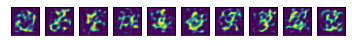

Epoch: [ 5] [  50/ 200] D_loss: 8.35362720, G_loss: 0.01348352
Epoch: [ 5] [ 100/ 200] D_loss: 4.55148029, G_loss: 0.01609600
Epoch: [ 5] [ 150/ 200] D_loss: 7.18195724, G_loss: 0.01306903
Epoch: [ 5] [ 200/ 200] D_loss: 6.77623940, G_loss: 0.00707889


<Figure size 72x720 with 0 Axes>

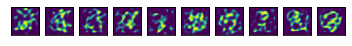

Epoch: [ 6] [  50/ 200] D_loss: 5.50138569, G_loss: 0.00502628
Epoch: [ 6] [ 100/ 200] D_loss: 4.29611444, G_loss: 0.01212603
Epoch: [ 6] [ 150/ 200] D_loss: 4.80694866, G_loss: 0.01474112
Epoch: [ 6] [ 200/ 200] D_loss: 3.95503759, G_loss: 0.01386052


<Figure size 72x720 with 0 Axes>

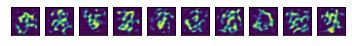

Epoch: [ 7] [  50/ 200] D_loss: 5.73540783, G_loss: 0.00654644
Epoch: [ 7] [ 100/ 200] D_loss: 4.40812826, G_loss: 0.00539905
Epoch: [ 7] [ 150/ 200] D_loss: 3.96608925, G_loss: 0.00766736
Epoch: [ 7] [ 200/ 200] D_loss: 6.06033278, G_loss: 0.01338857


<Figure size 72x720 with 0 Axes>

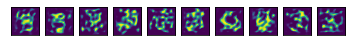

Epoch: [ 8] [  50/ 200] D_loss: 3.41394806, G_loss: 0.01296574
Epoch: [ 8] [ 100/ 200] D_loss: 4.78061056, G_loss: 0.01279926
Epoch: [ 8] [ 150/ 200] D_loss: 6.15948915, G_loss: 0.01015890
Epoch: [ 8] [ 200/ 200] D_loss: 5.51164055, G_loss: 0.01060402


<Figure size 72x720 with 0 Axes>

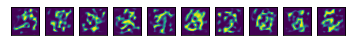

Epoch: [ 9] [  50/ 200] D_loss: 4.59256124, G_loss: 0.01156324
Epoch: [ 9] [ 100/ 200] D_loss: 4.59492254, G_loss: 0.00983953
Epoch: [ 9] [ 150/ 200] D_loss: 7.07836199, G_loss: 0.00961024
Epoch: [ 9] [ 200/ 200] D_loss: 6.16537046, G_loss: 0.00771397


<Figure size 72x720 with 0 Axes>

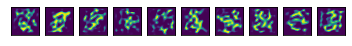

Epoch: [10] [  50/ 200] D_loss: 4.79809952, G_loss: 0.00831056
Epoch: [10] [ 100/ 200] D_loss: 6.21438599, G_loss: 0.00738800
Epoch: [10] [ 150/ 200] D_loss: 5.89500284, G_loss: 0.00733590


In [ ]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':152}

params['z_dim'] = 100
params['base_size'] = 64

gan2 = GAN(params)


gan2.train()